## Overview  

In this project I am working with data from Zillow to try to predict sales prices in the future. The goal is to see which zipcodes would make the most sense to invest in with regards to profit and return on investment.  

I will look at all three of these parameters when making my recommendations for these reasons: 
  
**Profit** - Tells us in dollar amount how much we estimate can be made as well as confidence intervels with a min and max profit margin.  
  
**Return on investment** - Percentage that can be gained, this metric can tell us if the amount we are able to make is a small or big precentage. This will help with understanding that even if a big profit can be made, this may be more of a risk with regards to small market swings. 

  
### City  

I will be looking at zipcodes in the city of Chicago, of which there are 41 zipcodes. 

<img src='Chicago_zipcodes.png'>

# Mod 4 Project - Starter Notebook

This notebook has been provided to you so that you can make use of the following starter code to help with the trickier parts of preprocessing the Zillow dataset. 

The notebook contains a rough outline the general order you'll likely want to take in this project. You'll notice that most of the areas are left blank. This is so that it's more obvious exactly when you should make use of the starter code provided for preprocessing. 

**_NOTE:_** The number of empty cells are not meant to infer how much or how little code should be involved in any given step--we've just provided a few for your convenience. Add, delete, and change things around in this notebook as needed!

# Some Notes Before Starting

This project will be one of the more challenging projects you complete in this program. This is because working with Time Series data is a bit different than working with regular datasets. In order to make this a bit less frustrating and help you understand what you need to do (and when you need to do it), we'll quickly review the dataset formats that you'll encounter in this project. 

## Wide Format vs Long Format

If you take a look at the format of the data in `zillow_data.csv`, you'll notice that the actual Time Series values are stored as separate columns. Here's a sample: 

<img src='~/../images/df_head.png'>

You'll notice that the first seven columns look like any other dataset you're used to working with. However, column 8 refers to the median housing sales values for April 1996, column 9 for May 1996, and so on. This This is called **_Wide Format_**, and it makes the dataframe intuitive and easy to read. However, there are problems with this format when it comes to actually learning from the data, because the data only makes sense if you know the name of the column that the data can be found it. Since column names are metadata, our algorithms will miss out on what dates each value is for. This means that before we pass this data to our ARIMA model, we'll need to reshape our dataset to **_Long Format_**. Reshaped into long format, the dataframe above would now look like:

<img src='~/../images/melted1.png'>

There are now many more rows in this dataset--one for each unique time and zipcode combination in the data! Once our dataset is in this format, we'll be able to train an ARIMA model on it. The method used to convert from Wide to Long is `pd.melt()`, and it is common to refer to our dataset as 'melted' after the transition to denote that it is in long format. 

# Helper Functions Provided

Melting a dataset can be tricky if you've never done it before, so you'll see that we have provided a sample function, `melt_data()`, to help you with this step below. Also provided is:

* `get_datetimes()`, a function to deal with converting the column values for datetimes as a pandas series of datetime objects
* Some good parameters for matplotlib to help make your visualizations more readable. 

Good luck!


# Step 1: Load the Data/Filtering for Chosen Zipcodes

In [1]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
import itertools
from sklearn.metrics import mean_squared_error
import folium

In [2]:
df = pd.read_csv('zillow_data.csv')

In [3]:
df.head()

RegionID  RegionName      City State              Metro CountyName  \
0     84654       60657   Chicago    IL            Chicago       Cook   
1     90668       75070  McKinney    TX  Dallas-Fort Worth     Collin   
2     91982       77494      Katy    TX            Houston     Harris   
3     84616       60614   Chicago    IL            Chicago       Cook   
4     93144       79936   El Paso    TX            El Paso    El Paso   

   SizeRank   1996-04   1996-05   1996-06   ...     2017-07  2017-08  2017-09  \
0         1  334200.0  335400.0  336500.0   ...     1005500  1007500  1007800   
1         2  235700.0  236900.0  236700.0   ...      308000   310000   312500   
2         3  210400.0  212200.0  212200.0   ...      321000   320600   320200   
3         4  498100.0  500900.0  503100.0   ...     1289800  1287700  1287400   
4         5   77300.0   77300.0   77300.0   ...      119100   119400   120000   

   2017-10  2017-11  2017-12  2018-01  2018-02  2018-03  2018-04  
0  1009600  1013300  1018700  1024400  1030700  1033800  1030600  
1   314100   315000   316600   318100   319600   321100   321800  
2   320400   320800   321200   321200   323000   326900   329900  
3  1291500  1296600  1299000  1302700  1306400  1308500  1307000  
4   120300   120300   120300   120300   120500   121000   121500  

[5 rows x 272 columns]

In [4]:
df1 = df.loc[df['City'] == 'Chicago']

In [5]:
df1.head()

RegionID  RegionName     City State    Metro CountyName  SizeRank  \
0      84654       60657  Chicago    IL  Chicago       Cook         1   
3      84616       60614  Chicago    IL  Chicago       Cook         4   
7      84640       60640  Chicago    IL  Chicago       Cook         8   
16     84646       60647  Chicago    IL  Chicago       Cook        17   
19     84620       60618  Chicago    IL  Chicago       Cook        20   

     1996-04   1996-05   1996-06   ...     2017-07  2017-08  2017-09  2017-10  \
0   334200.0  335400.0  336500.0   ...     1005500  1007500  1007800  1009600   
3   498100.0  500900.0  503100.0   ...     1289800  1287700  1287400  1291500   
7   216500.0  216700.0  216900.0   ...      798000   787100   776100   774900   
16  122700.0  122800.0  122800.0   ...      459600   461400   464300   466500   
19  142600.0  143100.0  143400.0   ...      462700   461200   459900   459200   

    2017-11  2017-12  2018-01  2018-02  2018-03  2018-04  
0   1013300  1018700  1024400  1030700  1033800  1030600  
3   1296600  1299000  1302700  1306400  1308500  1307000  
7    777900   777900   778500   780500   782800   782800  
16   467900   470600   474500   475100   472600   470200  
19   458700   457900   457400   459000   462500   464300  

[5 rows x 272 columns]

In [6]:
len(df1)

41

Checking for Null values

In [7]:
df.isna().sum()

RegionID         0
RegionName       0
City             0
State            0
Metro         1043
CountyName       0
SizeRank         0
1996-04       1039
1996-05       1039
1996-06       1039
1996-07       1039
1996-08       1039
1996-09       1039
1996-10       1039
1996-11       1039
1996-12       1039
1997-01       1039
1997-02       1039
1997-03       1039
1997-04       1039
1997-05       1039
1997-06       1039
1997-07       1038
1997-08       1038
1997-09       1038
1997-10       1038
1997-11       1038
1997-12       1038
1998-01       1036
1998-02       1036
              ... 
2015-11          0
2015-12          0
2016-01          0
2016-02          0
2016-03          0
2016-04          0
2016-05          0
2016-06          0
2016-07          0
2016-08          0
2016-09          0
2016-10          0
2016-11          0
2016-12          0
2017-01          0
2017-02          0
2017-03          0
2017-04          0
2017-05          0
2017-06          0
2017-07          0
2017-08     

Checking to see where those null values are

In [8]:
df1

RegionID  RegionName     City State    Metro CountyName  SizeRank  \
0        84654       60657  Chicago    IL  Chicago       Cook         1   
3        84616       60614  Chicago    IL  Chicago       Cook         4   
7        84640       60640  Chicago    IL  Chicago       Cook         8   
16       84646       60647  Chicago    IL  Chicago       Cook        17   
19       84620       60618  Chicago    IL  Chicago       Cook        20   
40       84615       60613  Chicago    IL  Chicago       Cook        41   
48       84630       60629  Chicago    IL  Chicago       Cook        49   
50       84627       60625  Chicago    IL  Chicago       Cook        51   
74       84621       60619  Chicago    IL  Chicago       Cook        75   
79       84612       60610  Chicago    IL  Chicago       Cook        80   
105      84613       60611  Chicago    IL  Chicago       Cook       106   
150      84622       60620  Chicago    IL  Chicago       Cook       151   
157      84635       60634  Chicago    IL  Chicago       Cook       158   
215      84628       60626  Chicago    IL  Chicago       Cook       216   
231      84647       60649  Chicago    IL  Chicago       Cook       232   
284      84618       60616  Chicago    IL  Chicago       Cook       285   
318      84624       60622  Chicago    IL  Chicago       Cook       319   
324      84617       60615  Chicago    IL  Chicago       Cook       325   
332      84641       60641  Chicago    IL  Chicago       Cook       333   
347      84656       60660  Chicago    IL  Chicago       Cook       348   
497      84610       60608  Chicago    IL  Chicago       Cook       498   
638      84638       60638  Chicago    IL  Chicago       Cook       639   
658      84639       60639  Chicago    IL  Chicago       Cook       659   
739      84631       60630  Chicago    IL  Chicago       Cook       740   
792      84642       60643  Chicago    IL  Chicago       Cook       793   
1012     84633       60632  Chicago    IL  Chicago       Cook      1013   
1360     84607       60605  Chicago    IL  Chicago       Cook      1361   
1454     84644       60645  Chicago    IL  Chicago       Cook      1455   
1496     84648       60651  Chicago    IL  Chicago       Cook      1497   
1727     84650       60653  Chicago    IL  Chicago       Cook      1728   
1990     84651       60654  Chicago    IL  Chicago       Cook      1991   
2360     84614       60612  Chicago    IL  Chicago       Cook      2361   
2420     84609       60607  Chicago    IL  Chicago       Cook      2421   
2585     84655       60659  Chicago    IL  Chicago       Cook      2586   
2830     84649       60652  Chicago    IL  Chicago       Cook      2831   
3149     84632       60631  Chicago    IL  Chicago       Cook      3150   
3156     84653       60656  Chicago    IL  Chicago       Cook      3157   
3960     84652       60655  Chicago    IL  Chicago       Cook      3961   
4040     84645       60646  Chicago    IL  Chicago       Cook      4041   
4362    399713       60642  Chicago    IL  Chicago       Cook      4363   
7863     84634       60633  Chicago    IL  Chicago       Cook      7864   

       1996-04   1996-05   1996-06   ...     2017-07  2017-08  2017-09  \
0     334200.0  335400.0  336500.0   ...     1005500  1007500  1007800   
3     498100.0  500900.0  503100.0   ...     1289800  1287700  1287400   
7     216500.0  216700.0  216900.0   ...      798000   787100   776100   
16    122700.0  122800.0  122800.0   ...      459600   461400   464300   
19    142600.0  143100.0  143400.0   ...      462700   461200   459900   
40    297900.0  300400.0  302600.0   ...     1015000  1017600  1020900   
48     93400.0   94100.0   94600.0   ...      157600   158600   159500   
50    148900.0  149300.0  149600.0   ...      452300   453600   456000   
74     76400.0   77000.0   77400.0   ...      128200   129000   129100   
79    435200.0  435200.0  435100.0   ...     1044200  1041800  1038100   
105        NaN       NaN       NaN   ... 

Seeing where this zipcode actually starts, as I will need to filter for that in the modeling later

In [9]:
df60611 =  df1.loc[df1['RegionName'] == 60611]

In [10]:
df60611.iloc[:, 214:]

2013-07    2013-08    2013-09    2013-10    2013-11    2013-12  \
105  1296700.0  1315900.0  1313900.0  1313500.0  1304200.0  1308000.0   

       2014-01    2014-02    2014-03    2014-04   ...     2017-07  2017-08  \
105  1317300.0  1319400.0  1314700.0  1316100.0   ...     1475200  1473900   

     2017-09  2017-10  2017-11  2017-12  2018-01  2018-02  2018-03  2018-04  
105  1469500  1472100  1477800  1486000  1497300  1508600  1508100  1493200  

[1 rows x 58 columns]

# Step 2: Reshape from Wide to Long Format

In [11]:
def melt_data(df):
    melted = pd.melt(df, id_vars=['RegionID', 'RegionName', 'City', 'State', 'Metro', 'CountyName', 'SizeRank'], var_name='time')
    melted['time'] = pd.to_datetime(melted['time'], infer_datetime_format=True)
    melted = melted.dropna(subset=['value'])
    return melted.groupby('time').aggregate({'value':'mean'})

In [12]:
def melt_df(df):
    merged = []
    for zipcode in df.RegionName:
        melted = melt_data(df.loc[df['RegionName'] == zipcode])
        row = df.loc[df['RegionName'] == zipcode].iloc[:,:7]
        rows = pd.concat([row]*len(melted), ignore_index=True)
        merge = pd.concat([rows, melted.reset_index()], axis= 1)
        merged.append(merge)
    melted_df = pd.concat(merged)
    return melted_df

In [13]:
melted_df1 = melt_df(df1)

In [14]:
melted_df1.isna().sum()

RegionID      0
RegionName    0
City          0
State         0
Metro         0
CountyName    0
SizeRank      0
time          0
value         0
dtype: int64

In [15]:
melted_df1.head()

RegionID  RegionName     City State    Metro CountyName  SizeRank  \
0     84654       60657  Chicago    IL  Chicago       Cook         1   
1     84654       60657  Chicago    IL  Chicago       Cook         1   
2     84654       60657  Chicago    IL  Chicago       Cook         1   
3     84654       60657  Chicago    IL  Chicago       Cook         1   
4     84654       60657  Chicago    IL  Chicago       Cook         1   

        time     value  
0 1996-04-01  334200.0  
1 1996-05-01  335400.0  
2 1996-06-01  336500.0  
3 1996-07-01  337600.0  
4 1996-08-01  338500.0

In [16]:
len(melted_df1)

10658

Set the time column as the index

In [17]:
melted_df1.set_index('time', inplace=True)

# Step 3: EDA and Visualization

In [18]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 12}

plt.rc('font', **font)

# NOTE: if your visualizations are too cluttered to read, try calling 'plt.gcf().autofmt_xdate()'!

Making a general visual, just to see the general trend of all the zipcodes

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


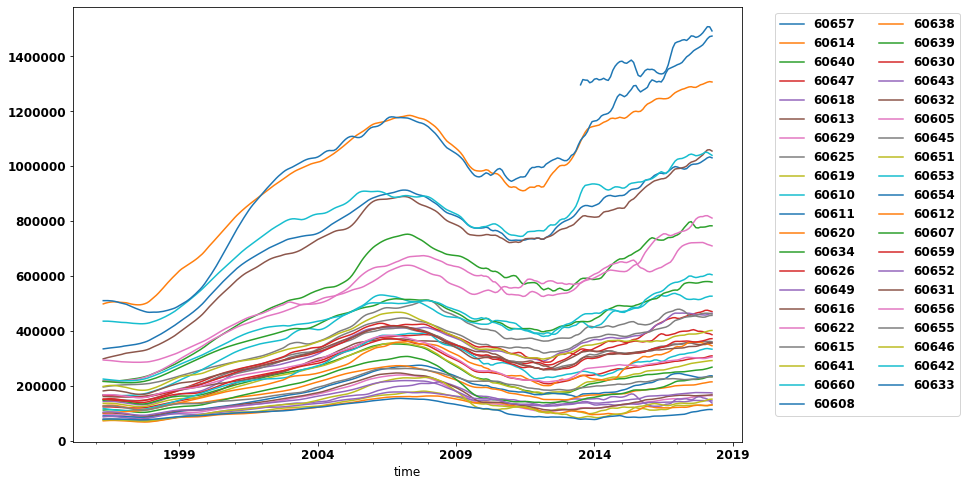

In [19]:
plt.figure(figsize=(12,8))
for zipcode in melted_df1.RegionName.unique():
    melted_df1.loc[melted_df1['RegionName'] == zipcode].value.plot(label=zipcode)
plt.legend(bbox_to_anchor=(1.04,1), loc="upper left", ncol=2)
plt.show()
    

I want to checkout the upper part of this graph as the lower part seems to not have much change from the start to the end. As it seems that the ones that have the most change start higher as well, I will just filter for the 10 best means and that should give me what I am looking for.

In [20]:
zips = pd.DataFrame()
zipsdict = {}
for zipcode in melted_df1.RegionName.unique():
    zipsdict[zipcode] = melted_df1.loc[melted_df1['RegionName'] == zipcode].value.mean()
zips['zipcode'] = zipsdict.keys()
zips['means'] = zipsdict.values()
highmean_list = list(zips.sort_values(by='means', ascending=False).zipcode[:10])

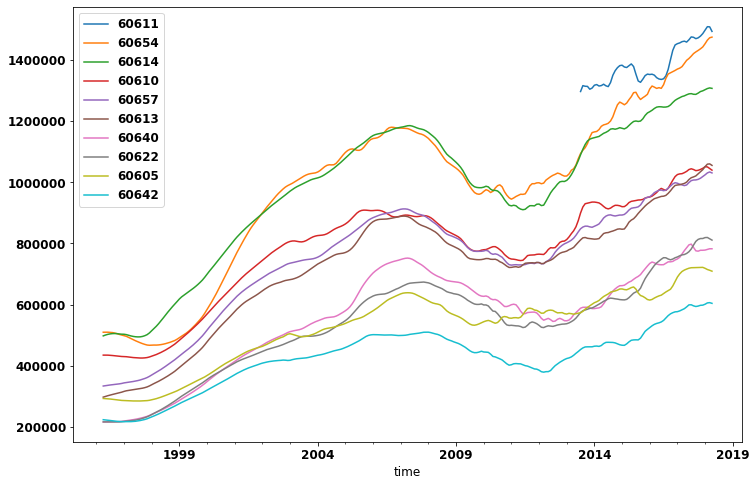

In [21]:
plt.figure(figsize=(12,8))
for zipcode in highmean_list:
    zipdf = melted_df1.loc[melted_df1['RegionName'] == zipcode].value
    zipdf.plot(label=zipcode)
plt.legend()
plt.show()

Seems I got what I am looking for, from 1996 until 2019, these seem to be the most growing zipcodes, though what effect that will have on future growth remains to be seen. Might be interesting to check back at this after I figure out the best ones by predictionto see if they match up or not

Just want to see a basic breakdown of one zipcode to see the seasonality and trends.

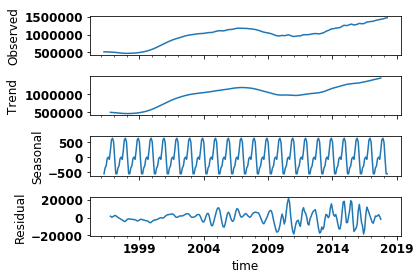

In [22]:
decomposition = seasonal_decompose(melted_df1.loc[melted_df1['RegionName'] == 60654].value)
decomposition.plot();

Seems to be very seasonal and the residuals seem to be more volatile from the start of the corresponding drop in the main graph, which seems to relate to the market crash.

# Step 4: ARIMA Modeling

Making a test on one zipcode to then use the code for everything

In [55]:
test = melted_df1.loc[melted_df1['RegionName'] == 60654]

In [56]:
ARIMA_MODEL = sm.tsa.statespace.SARIMAX(test.value,
                                order=(0, 1, 1),
                                seasonal_order=(0, 1, 1, 12), 
                                enforce_stationarity=False, 
                                enforce_invertibility=False)

# Fit the model and print results
output = ARIMA_MODEL.fit()
display(output.summary().tables[0], output.summary().tables[1], output.summary().tables[2])

C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


<class 'statsmodels.iolib.table.SimpleTable'>

<class 'statsmodels.iolib.table.SimpleTable'>

<class 'statsmodels.iolib.table.SimpleTable'>

Printing the diagnostics of the model

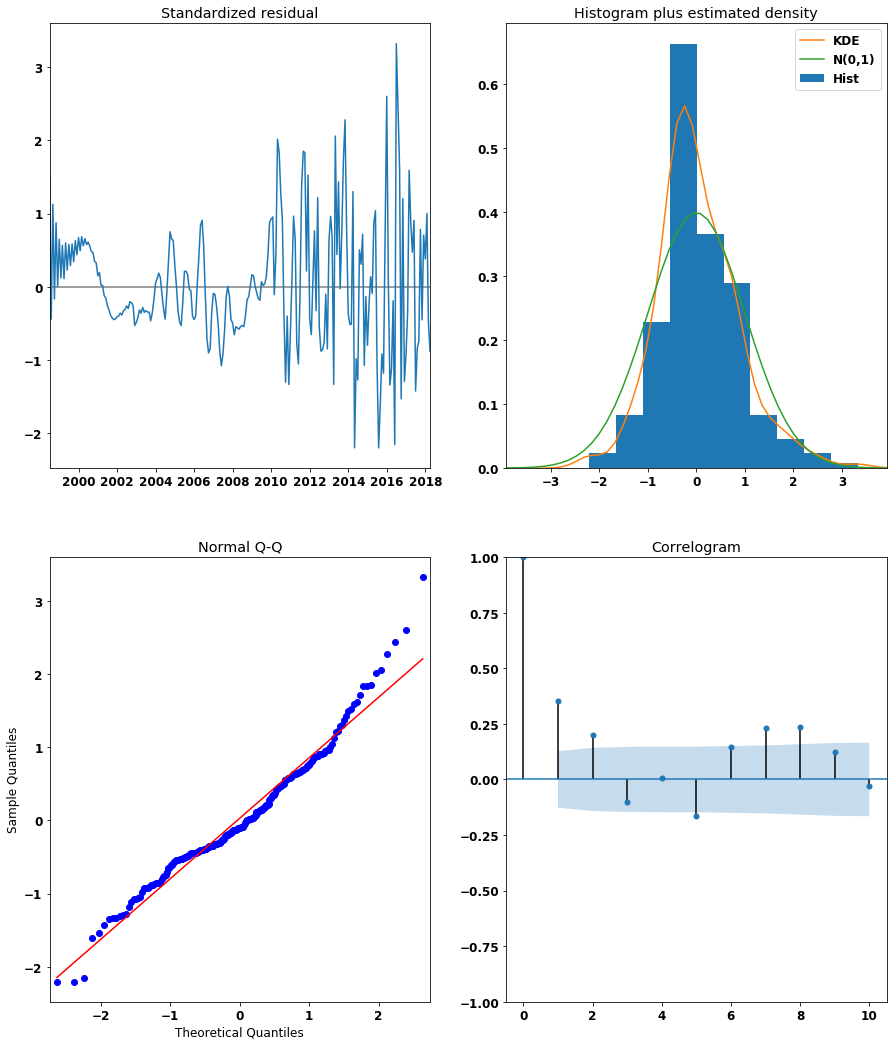

In [57]:
output.plot_diagnostics(figsize=(15, 18))
plt.show()

Checking getting the predictions along with the lower and upper confidence intervals

In [58]:
pred = output.get_prediction(start=pd.to_datetime('2015-01-01'), dynamic=False)
pred_conf = pred.conf_int()

In [59]:
b = {}
b['a'] = pred_conf[pred_conf.index == '2015-02-01']['lower value'][0]

In [60]:
pred_conf[pred_conf.index == '2015-02-01']['lower value']

2015-02-01    1.241398e+06
Freq: MS, Name: lower value, dtype: float64

In [61]:
b

{'a': 1241397.978369812}

In [62]:
pred_conf['upper value'].mean()

1363747.028573276

In [63]:
pred.predicted_mean['2018-01-01']

1450282.9554504615

Making a graph of the predictions and the original data

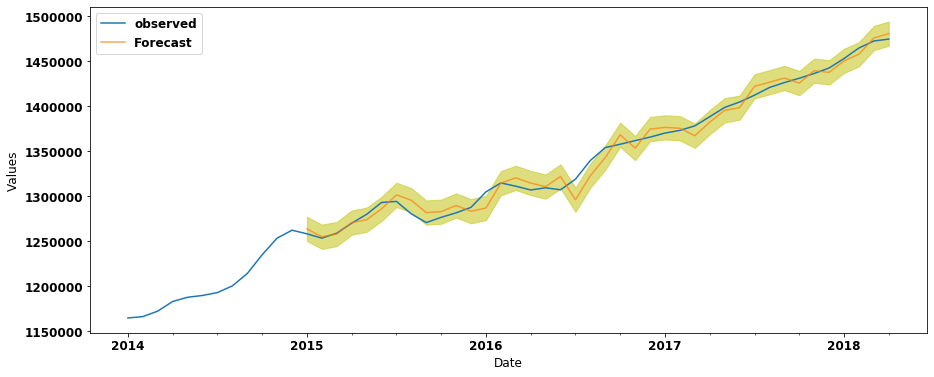

In [64]:
rcParams['figure.figsize'] = 15, 6

#Plot observed values
ax = test['2014':].value.plot(label='observed')

#Plot predicted values
pred.predicted_mean.plot(ax=ax, label='Forecast', alpha=.7)

#Plot the range for confidence intervals
ax.fill_between(pred_conf.index,
                pred_conf.iloc[:, 0],
                pred_conf.iloc[:, 1], color='y', alpha=.5)

#Set axes labels
ax.set_xlabel('Date')
ax.set_ylabel('Values')
plt.legend()

plt.show()

Checking the RMSE

In [66]:
test_forecasted = pred.predicted_mean
test_truth = test['2017':].value
test_forecasted = test_forecasted['2017':]
# Compute the root mean square error
error = mean_squared_error(test_forecasted, test_truth)
error = np.sqrt(error)
print(f'The RMSE of our forecasts is {error}')

The RMSE of our forecasts is 5988.4759223316005


Our predictions are within about 6,000 dollars. Meaning about give or take 3,000 dollars. This is not bad at all

I would like to figure out the best parameters to use for the model, based on AIC.  
First I will generate the possible combinations and then get the best one for each zipcode

In [34]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

# Generate all different combinations of p, q and q triplets
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal p, q and q triplets
pdqs = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [35]:
best_combs = []
for zipcode in melted_df1.RegionName.unique():
    ans = []
    for comb in pdq:
        for combs in pdqs:
            try:
                mod = sm.tsa.statespace.SARIMAX(melted_df1.loc[melted_df1['RegionName'] == zipcode].value,
                                                order=comb,
                                                seasonal_order=combs,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)

                output = mod.fit()
                ans.append([zipcode, comb, combs, output.aic])
    #             print(f'ARIMA {comb} x {combs}12 : AIC Calculated ={output.aic}')
            except:
                continue
    best_combs.append(sorted(ans, key=lambda x: x[3])[0])

C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided

C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided

C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was

C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided

C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided

C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided

C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency inform

C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided

C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was

C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided

C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided

C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided

C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided

C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was

C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed 

C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided

C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided

C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided

C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was

C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was

C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed 

C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided

C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided

C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided

C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided

C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided

C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided

C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided

C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided

C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided

C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided

C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided

C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was

C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided

C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided

C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided

C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided

C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided

C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided

C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided

C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided

C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided

C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided

C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided

C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided

C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided

C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided

C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided

C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was

C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided

C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided

C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimizatio

C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided

C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency inform

C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided

C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided

C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided

C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided

C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was

C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was

C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided

C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided

C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided

C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided

C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided

C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was

C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided

C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided

C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided

C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided

C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimizatio

In [36]:
best_combs

[[60657, (1, 1, 1), (1, 1, 1, 12), 4305.406362019583],
 [60614, (1, 1, 1), (1, 1, 1, 12), 4391.733980410626],
 [60640, (1, 1, 1), (1, 1, 1, 12), 4436.878941715418],
 [60647, (1, 1, 1), (1, 1, 1, 12), 4038.817320468567],
 [60618, (1, 1, 1), (1, 1, 1, 12), 3891.9160021434973],
 [60613, (1, 1, 1), (1, 1, 1, 12), 4312.848675944981],
 [60629, (1, 1, 1), (0, 1, 1, 12), 3526.6441576089346],
 [60625, (1, 1, 1), (1, 1, 1, 12), 3924.101672212387],
 [60619, (1, 1, 1), (1, 1, 1, 12), 3788.2382601623335],
 [60610, (1, 1, 1), (1, 1, 1, 12), 4423.624017354134],
 [60611, (0, 1, 1), (1, 1, 0, 12), 710.5497875859761],
 [60620, (1, 1, 1), (1, 1, 1, 12), 3739.7306069697534],
 [60634, (1, 1, 1), (1, 1, 1, 12), 3740.9715825555368],
 [60626, (1, 1, 1), (1, 1, 1, 12), 4155.327103491825],
 [60649, (1, 1, 1), (0, 1, 1, 12), 4053.1804781073147],
 [60616, (1, 1, 1), (1, 1, 1, 12), 3976.9343483614157],
 [60622, (1, 1, 1), (1, 1, 1, 12), 4358.770359183581],
 [60615, (1, 1, 1), (1, 1, 1, 12), 4192.493783768519],
 [6

These are the best combinations for each zipcode, using 12 for seasonality and a 0 or a 1 for everything else.  
I will now try to check changing everything, including seasonality to see which ones are the best

Make a function for creating an image with the original data, and the predicted data, along with the forcasted data and the confidence intervals

In [37]:
def make_pred_image(df, test_forecasted, forcast, zipcode=None):
    rcParams['figure.figsize'] = 15, 6

    #Plot observed values
    ax = df['2015':].plot(label='observed')

    #Plot predicted values
    test_forecasted['2015-01-01':].plot(ax=ax, label='Predicted', alpha=.7)
    
    forcast.predicted_mean.plot(ax=ax, label='Forecast', alpha=.7)

    #Plot the range for confidence intervals
    ax.fill_between(pred_conf.index,
                    pred_conf.iloc[:, 0],
                    pred_conf.iloc[:, 1], color='y', alpha=.5)

    #Set axes labels
#     ax.title(zipcode)
    ax.set_xlabel('Date')
    ax.set_ylabel('Values')
    plt.legend()

    plt.show()
    return None

I am using a loop to get predictions for each zipcode based on the best combinations of parameters.  
It will also print out a graph for each zipcode along with the diagnostics.  
I put all the metrics I want into dictionaries with the zipcode as the key and the metric as the value.  
I also setup a dataframe and then make each dictionary correspond to a column in the dataframe

C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


60657


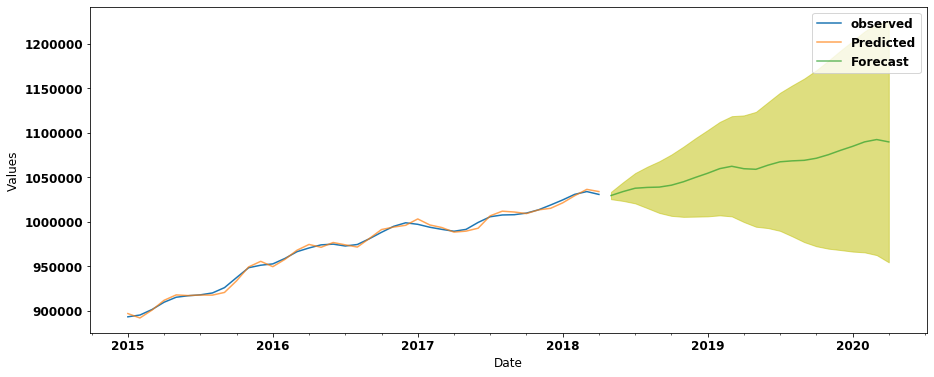

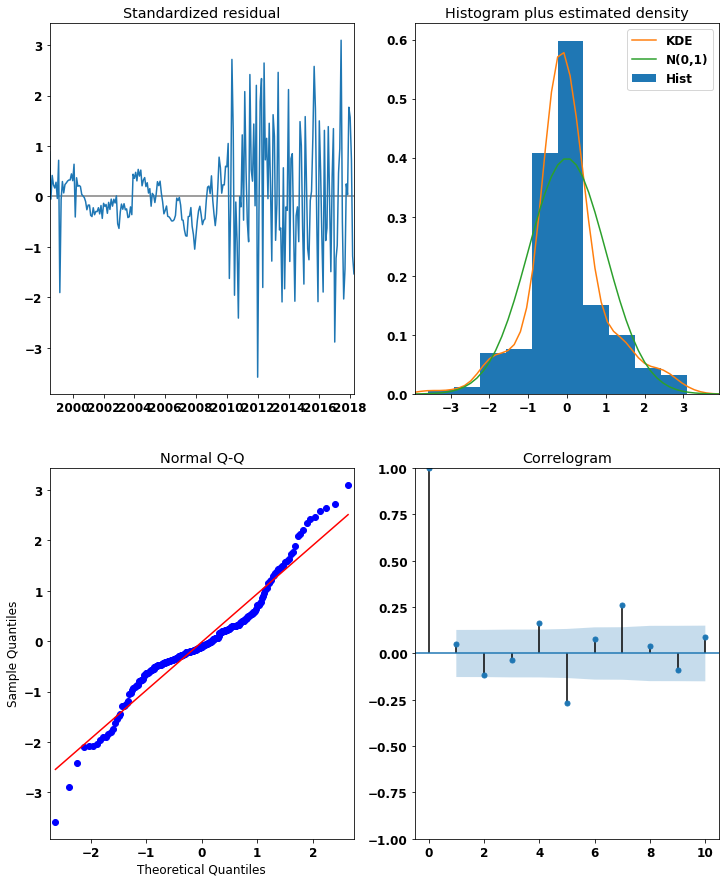

C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


60614


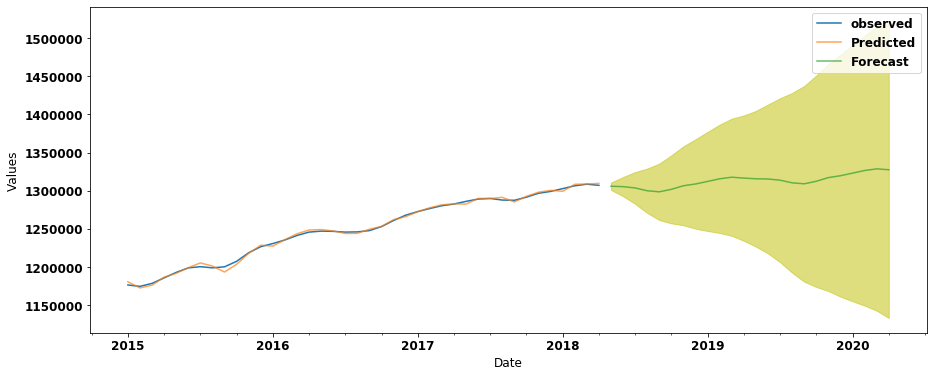

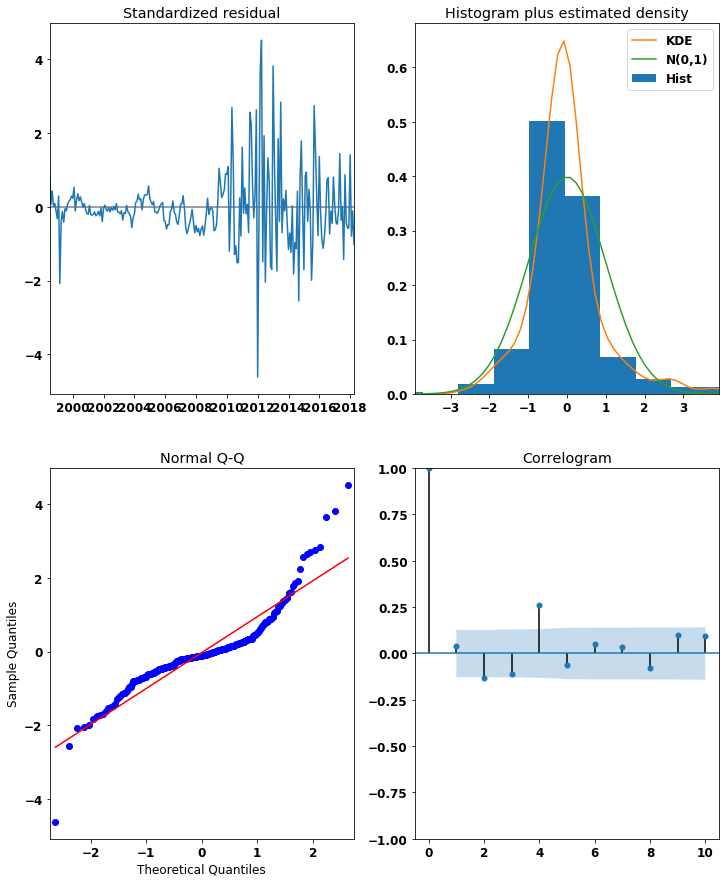

C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


60640


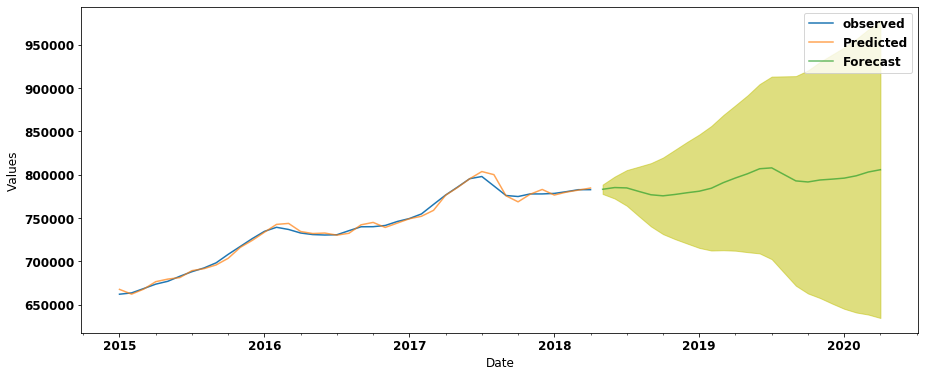

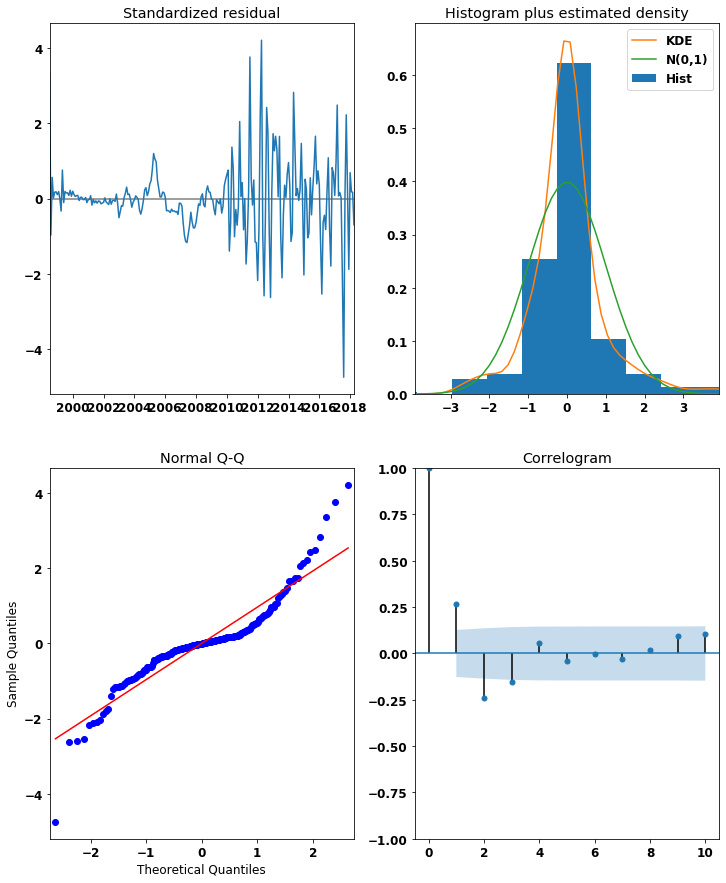

C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


60647


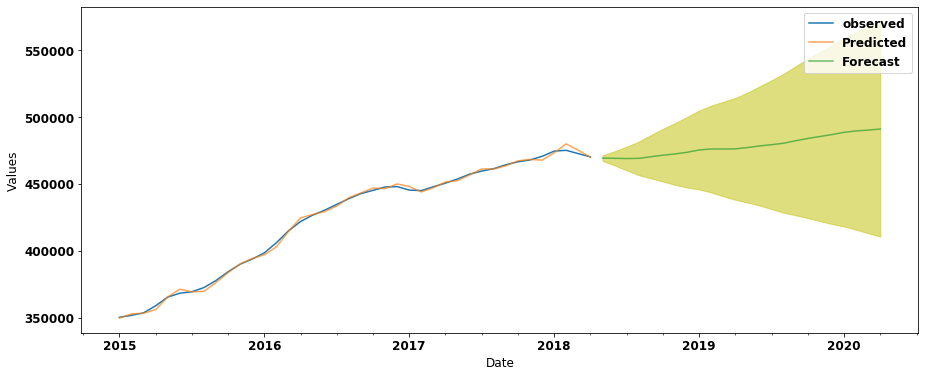

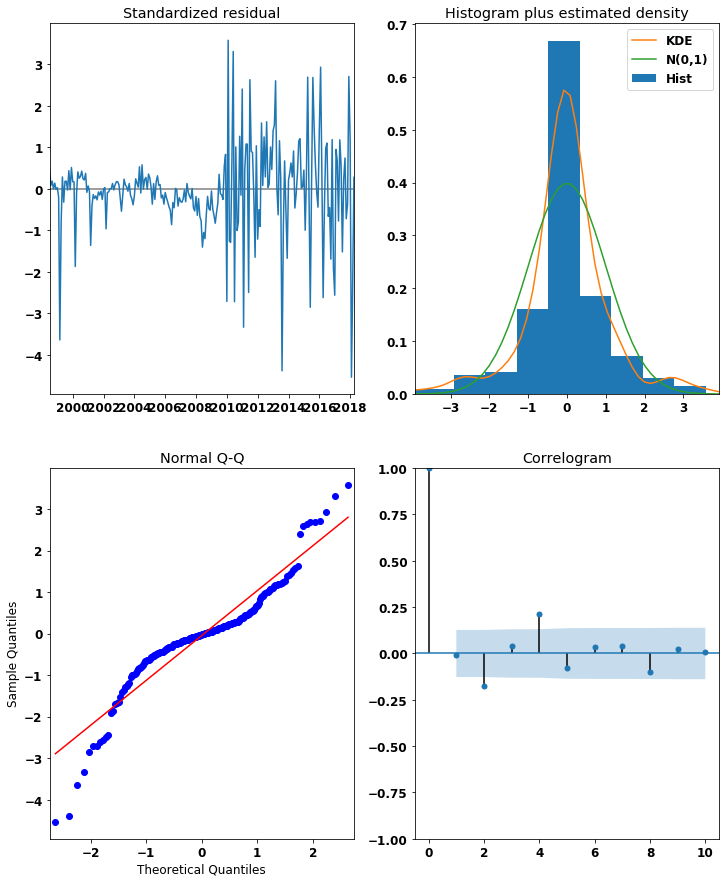

C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


60618


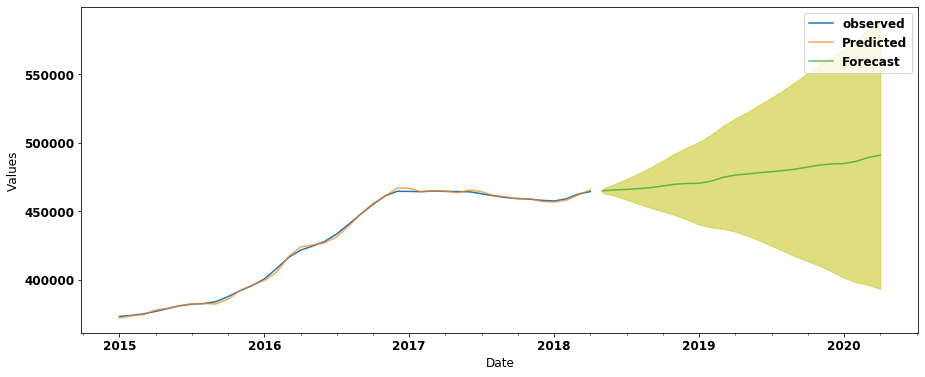

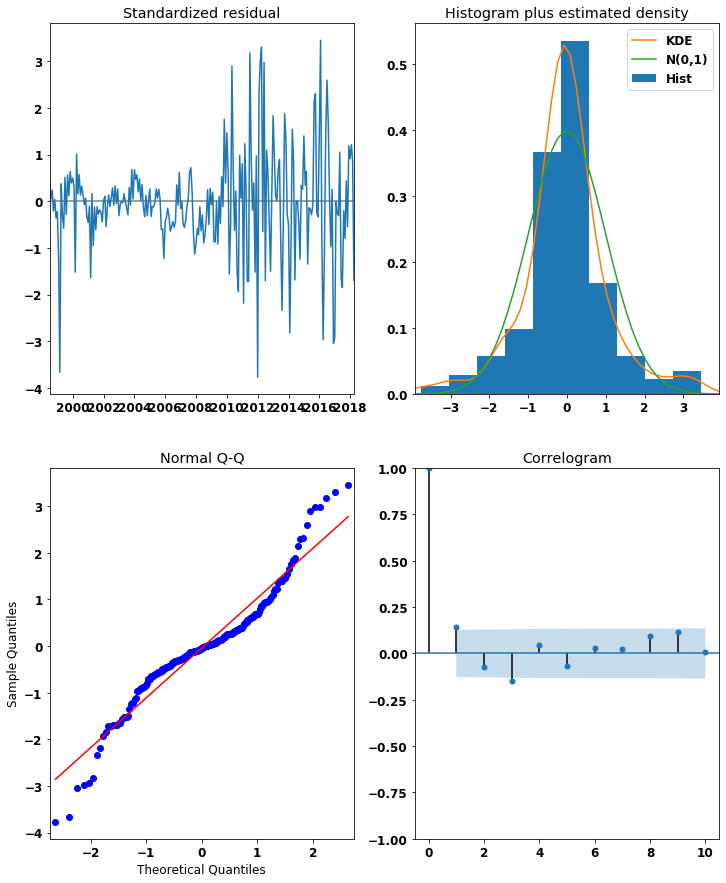

C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


60613


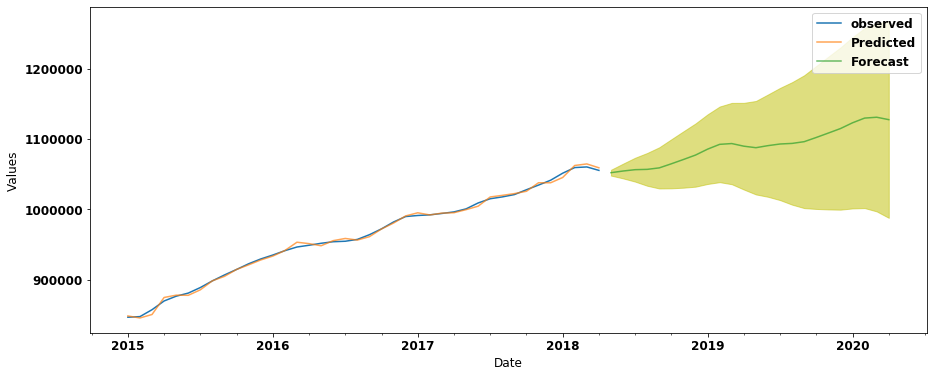

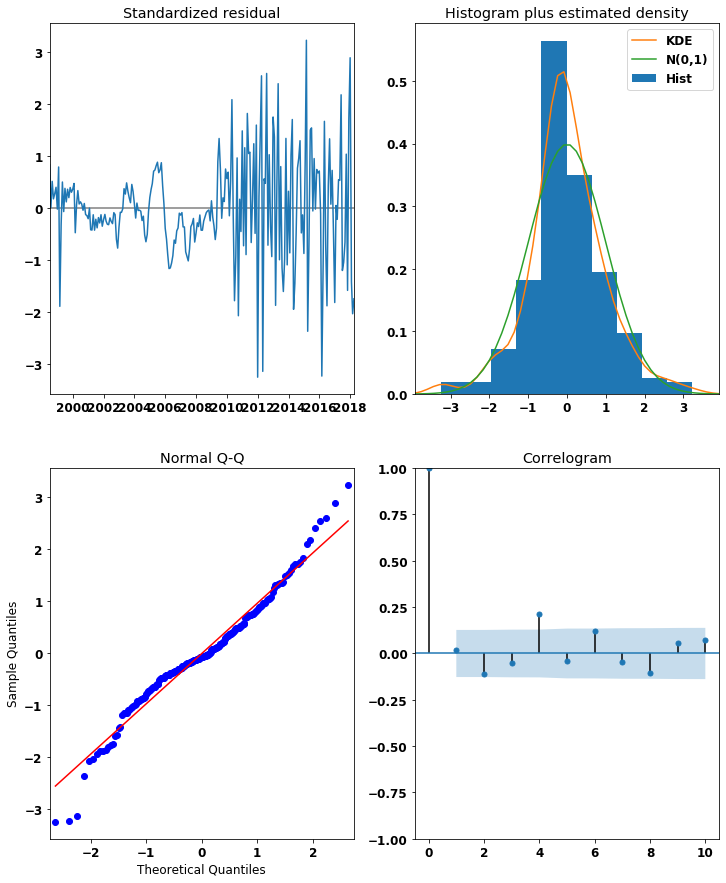

C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


60629


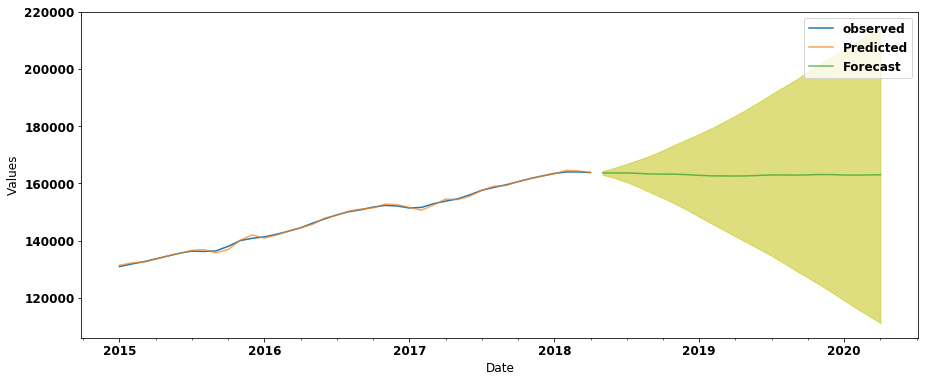

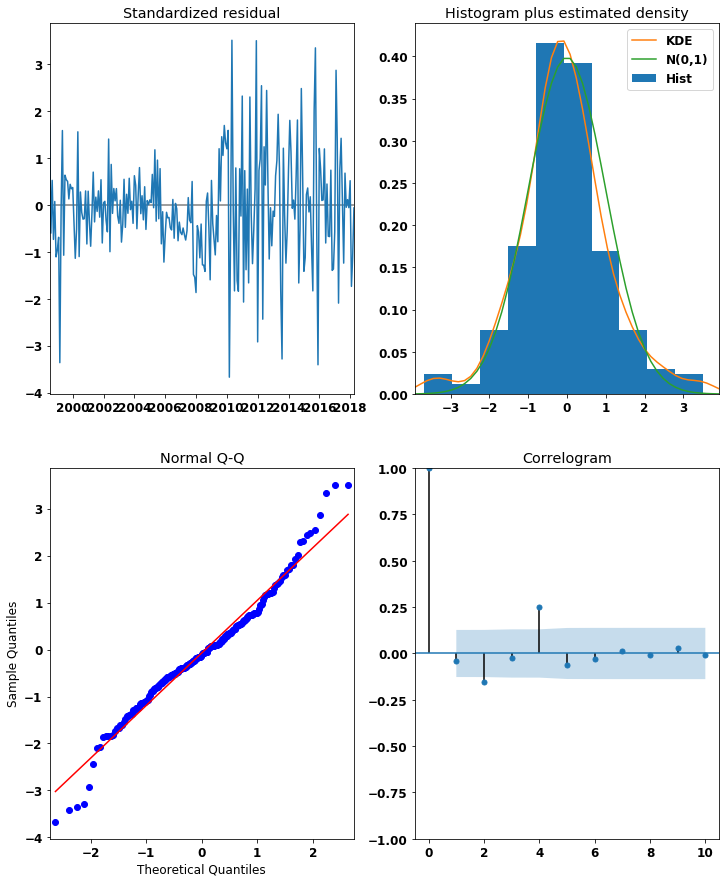

C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


60625


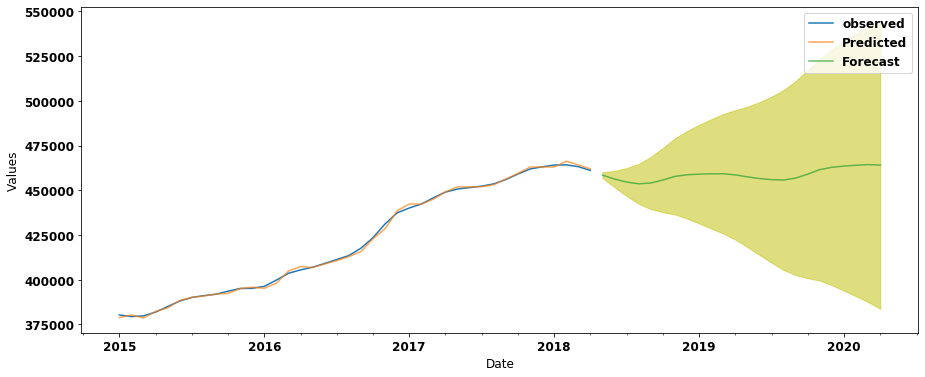

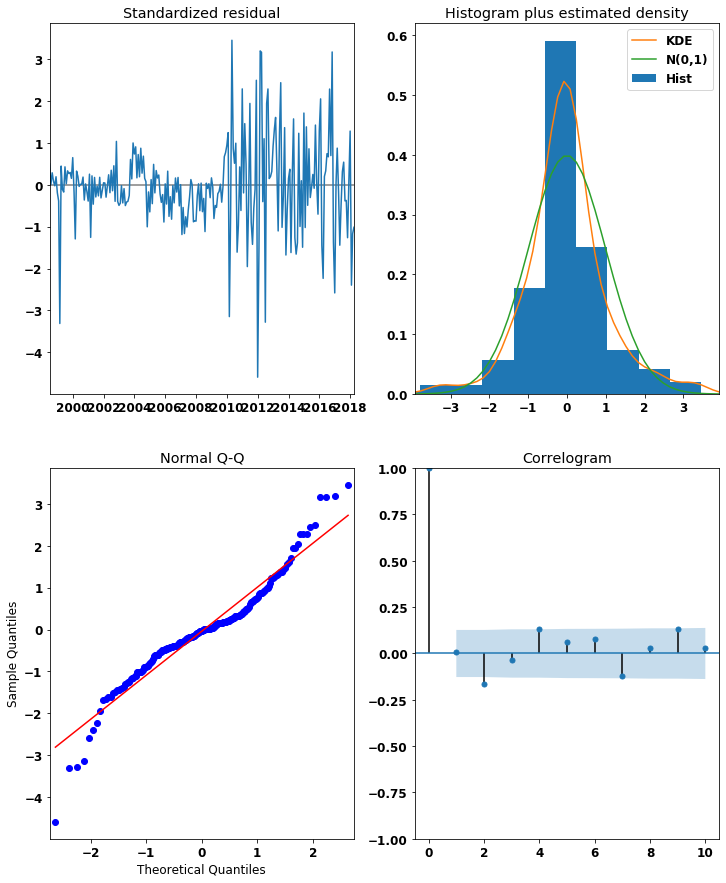

C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


60619


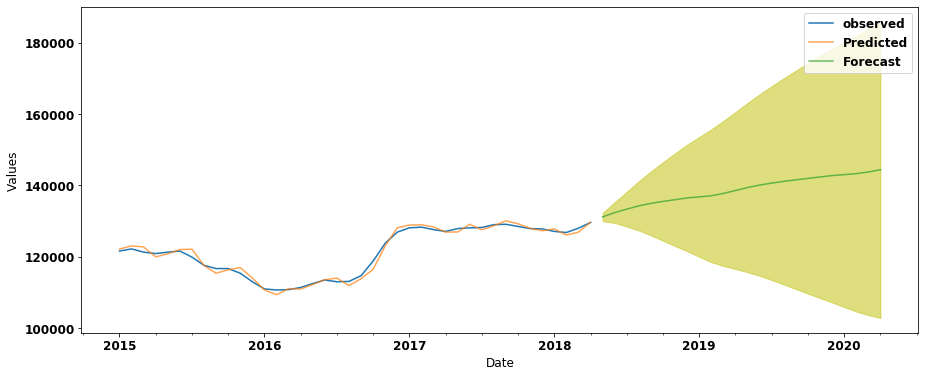

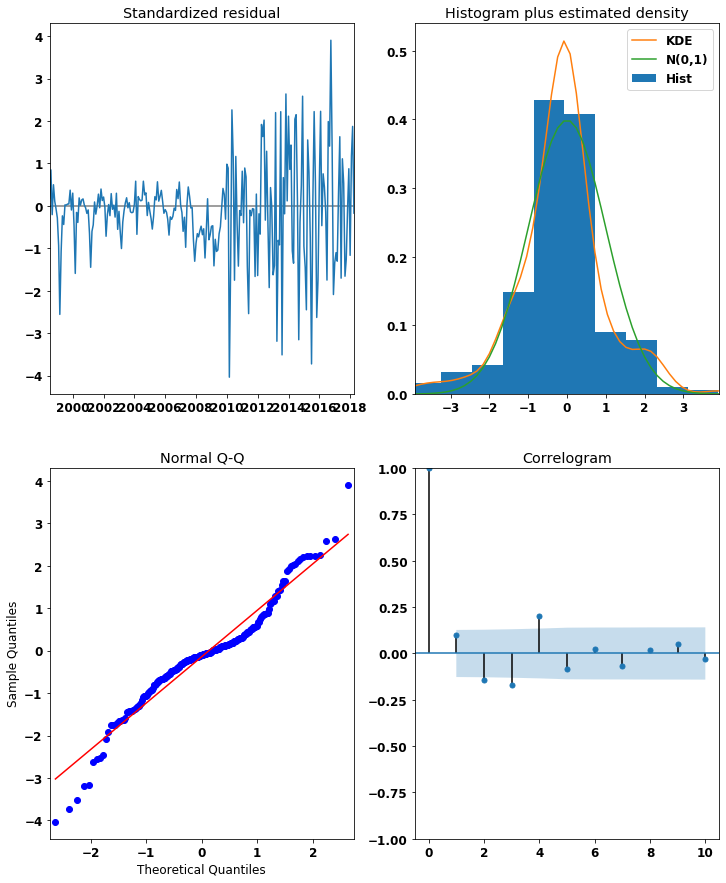

C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


60610


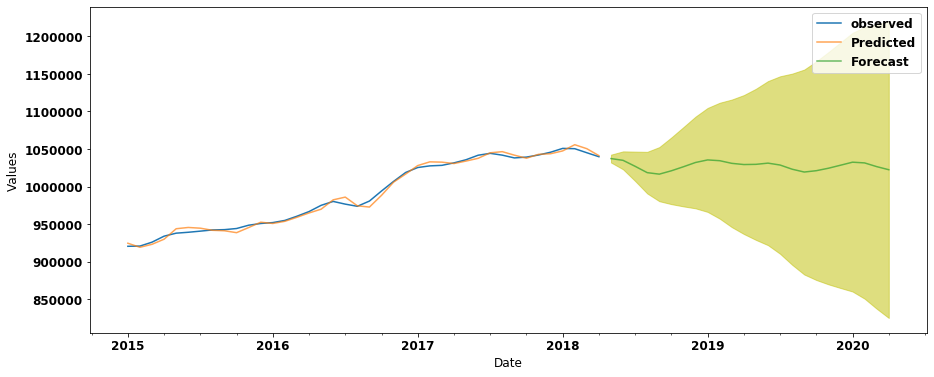

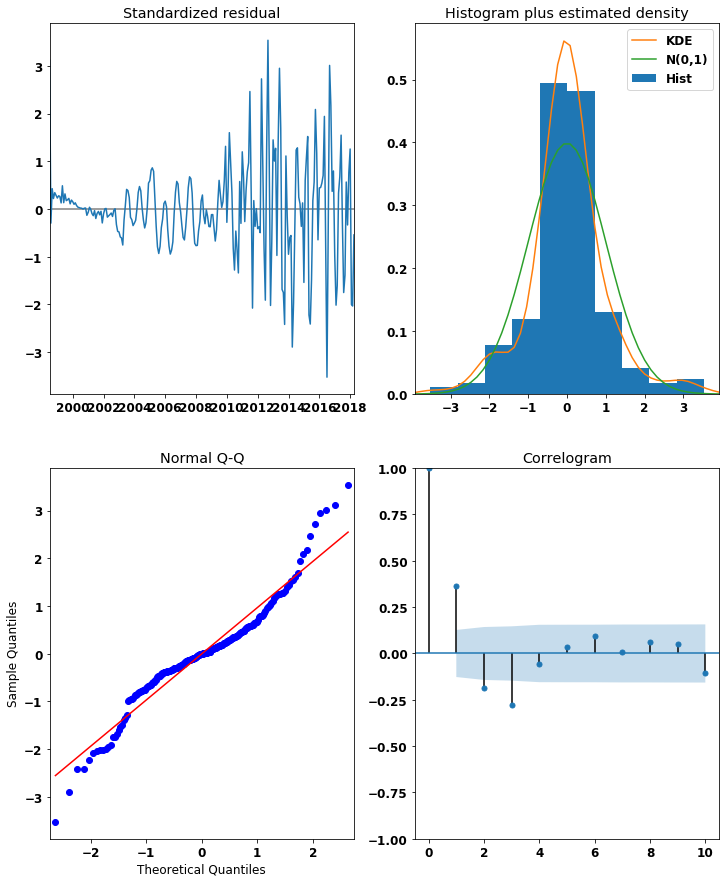

C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


60611


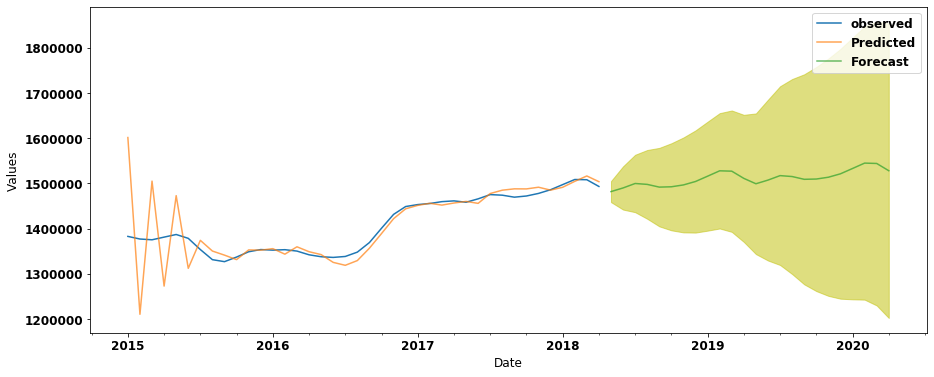

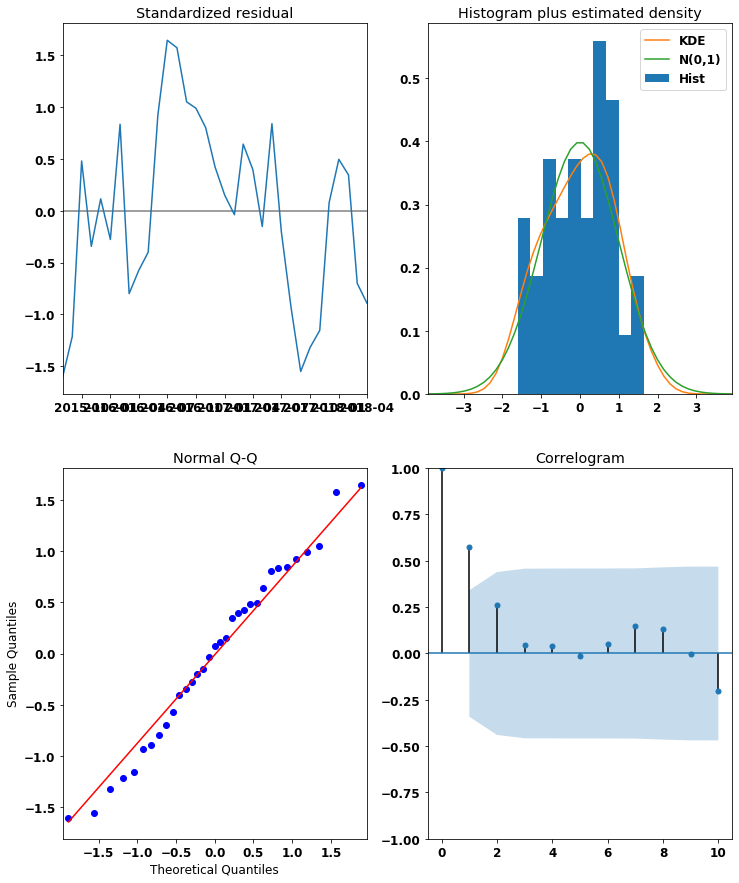

C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


60620


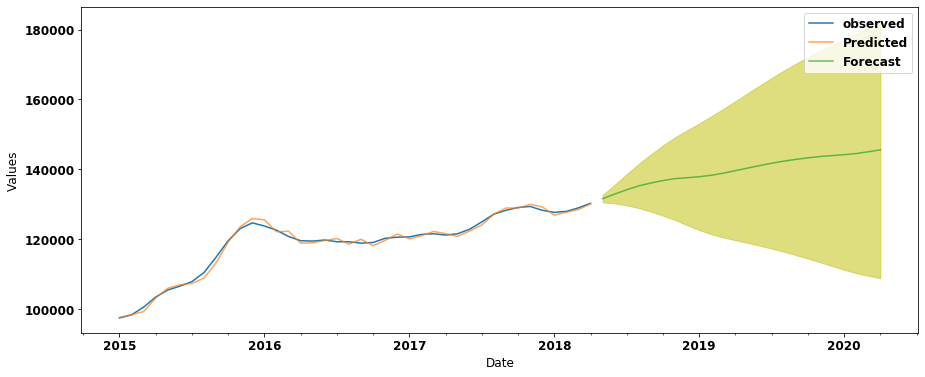

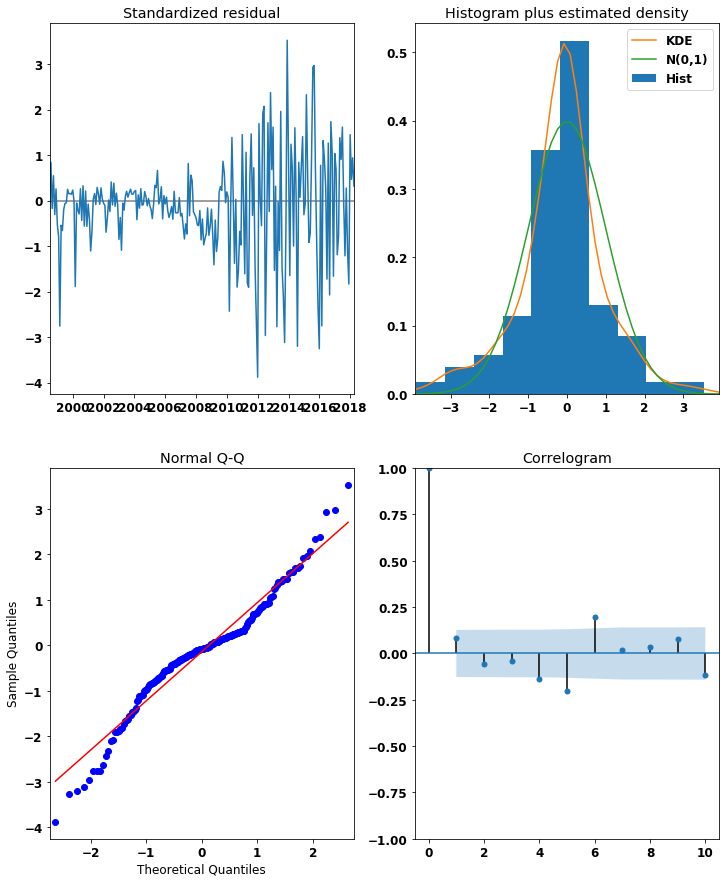

C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


60634


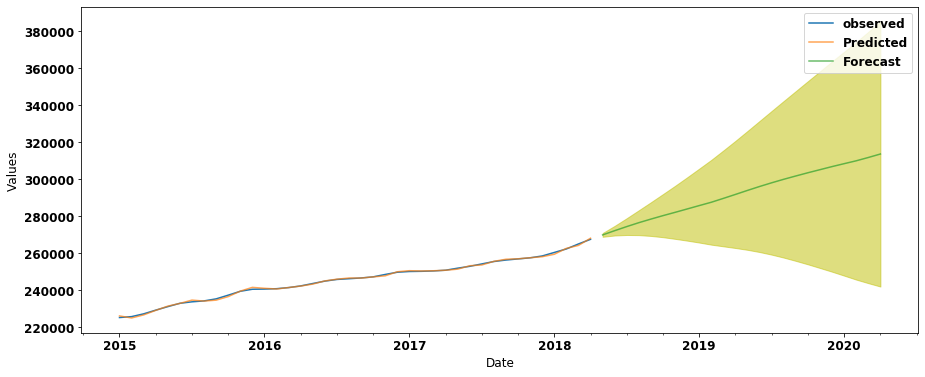

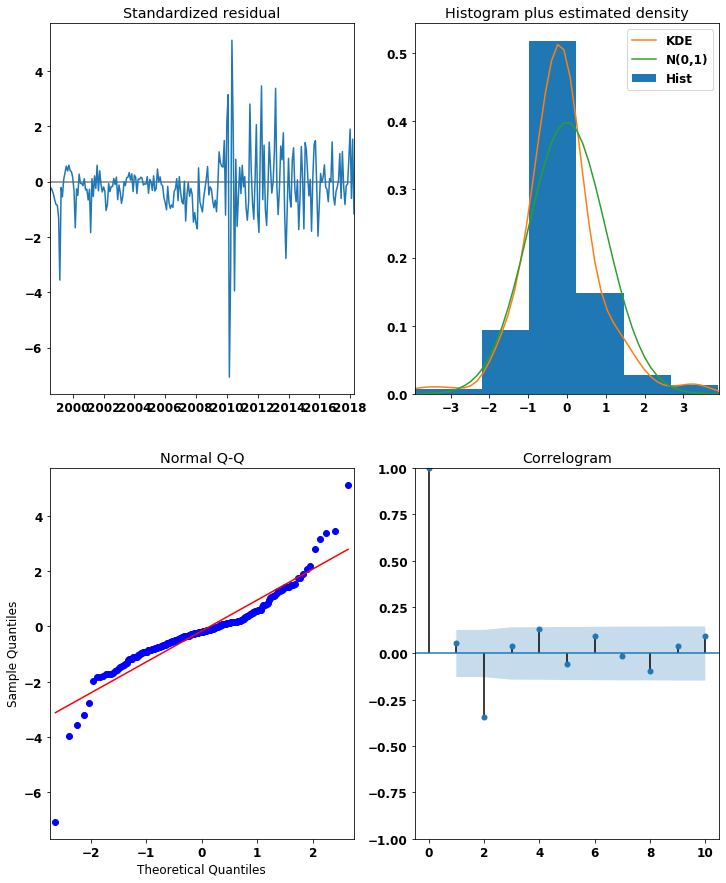

C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


60626


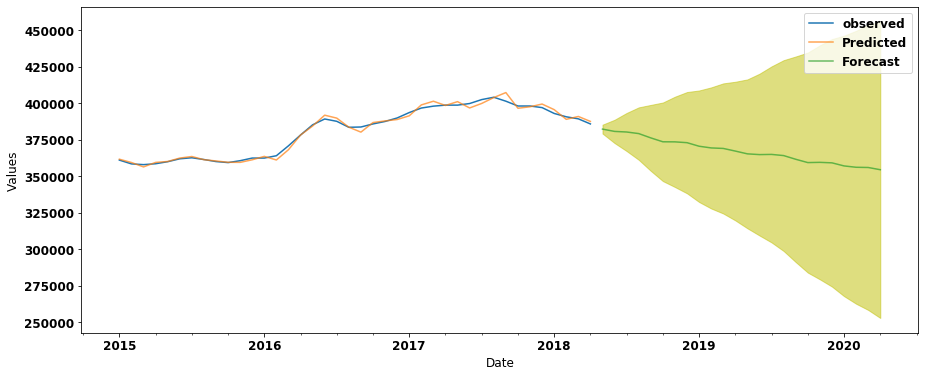

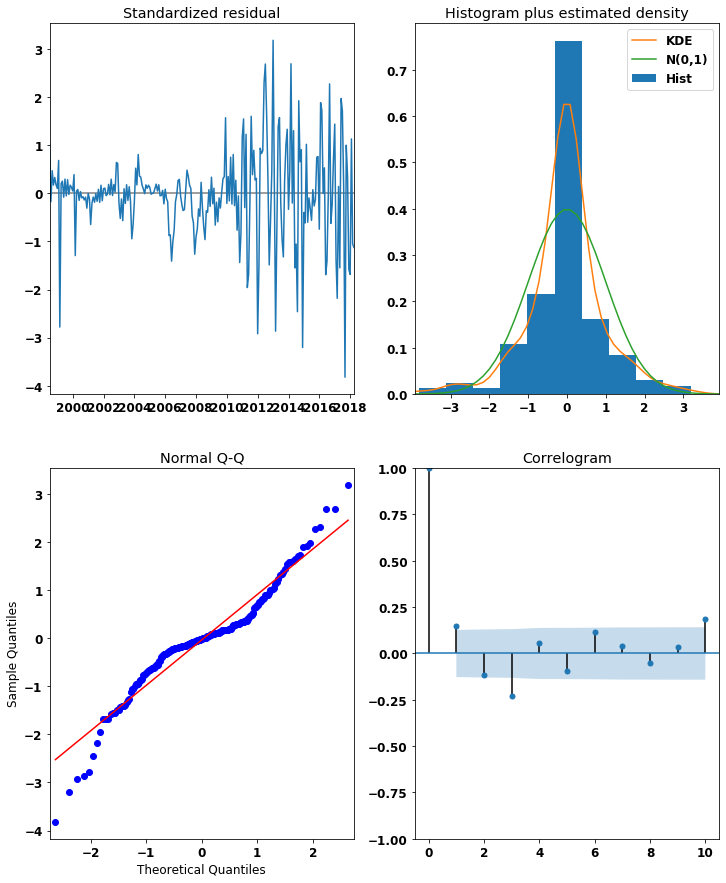

C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


60649


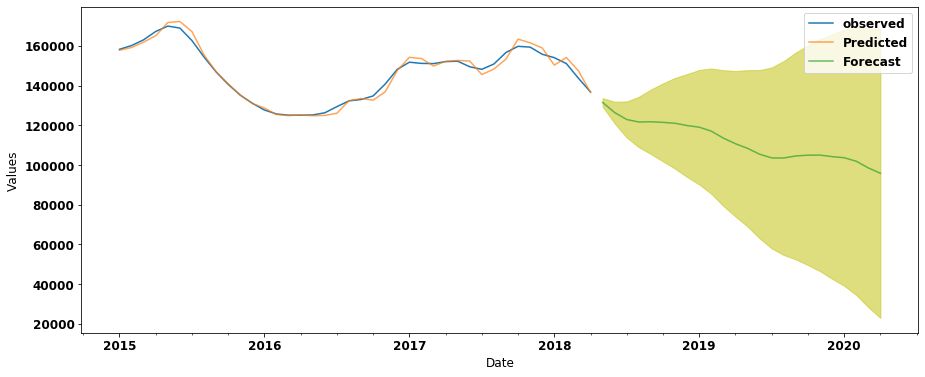

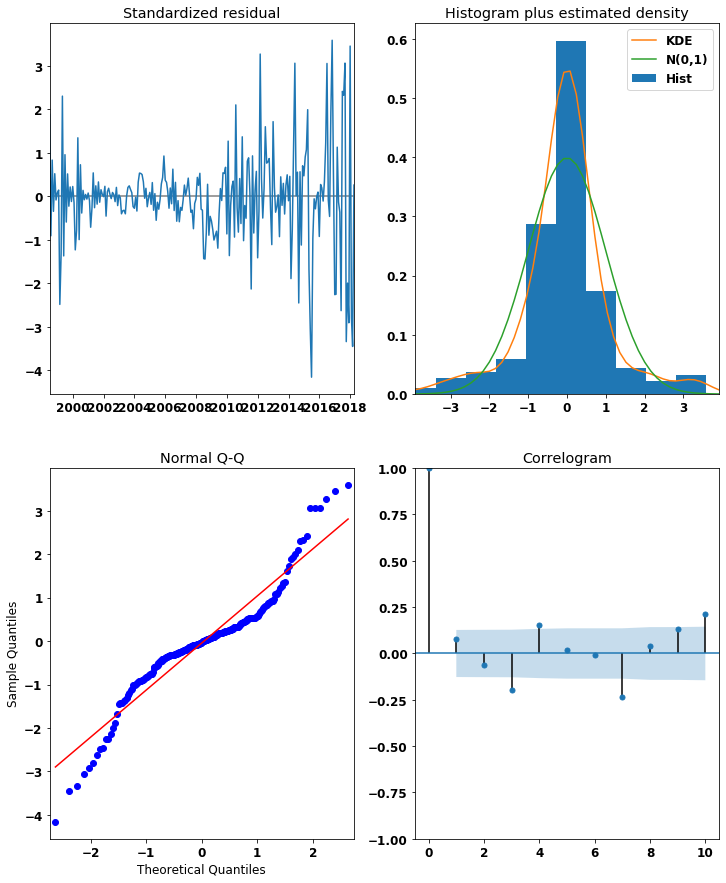

C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


60616


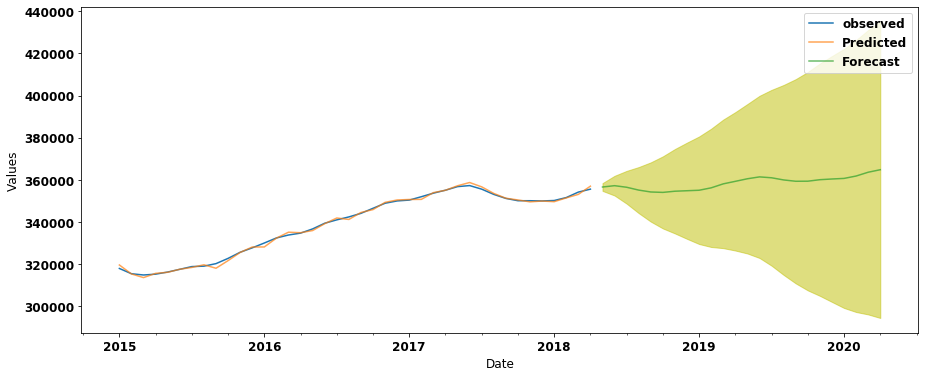

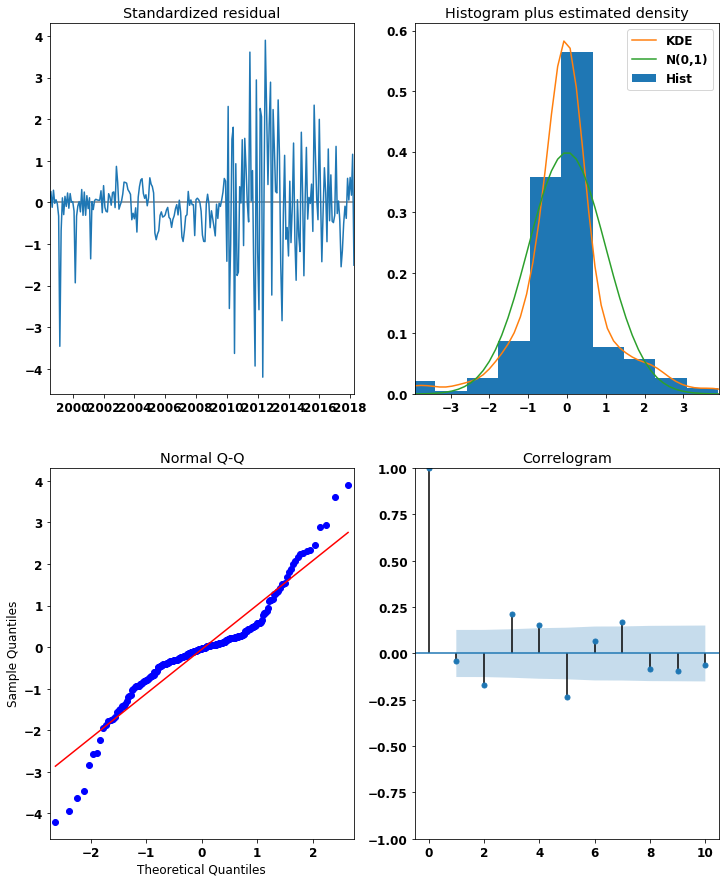

C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


60622


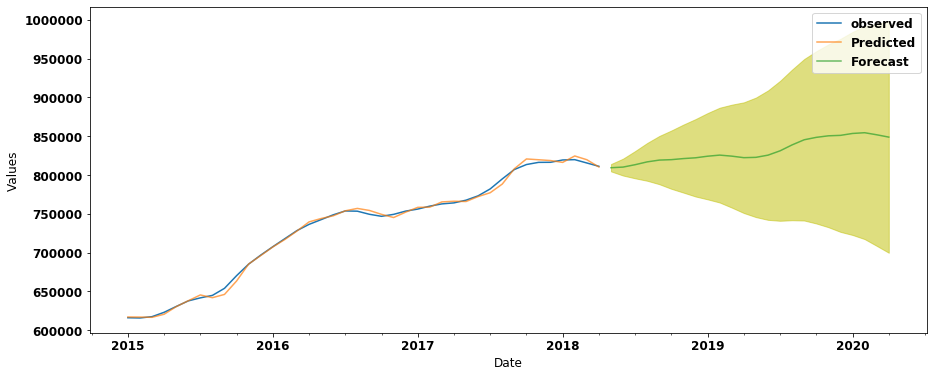

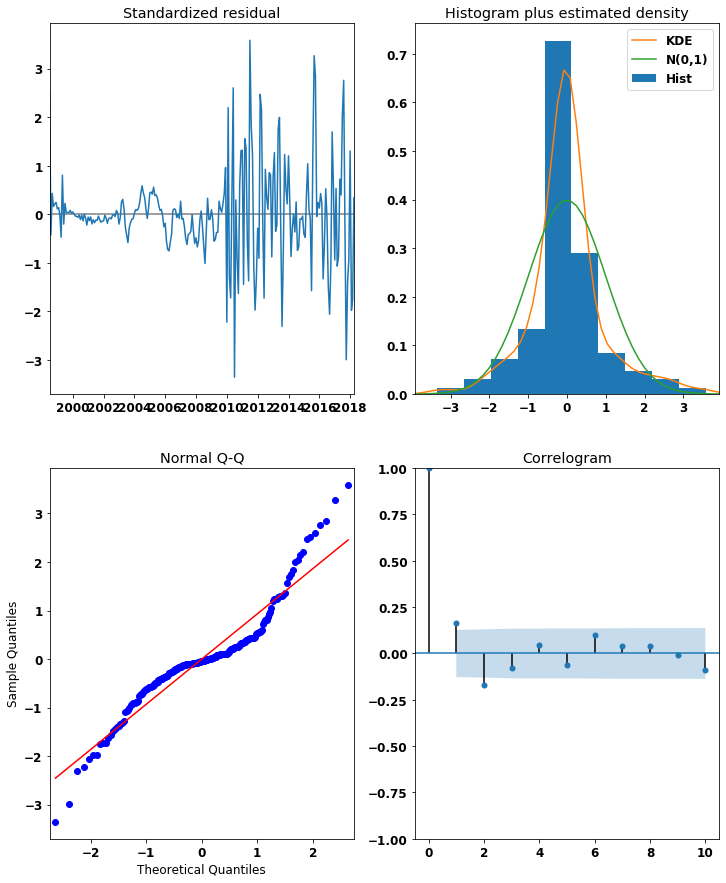

C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


60615


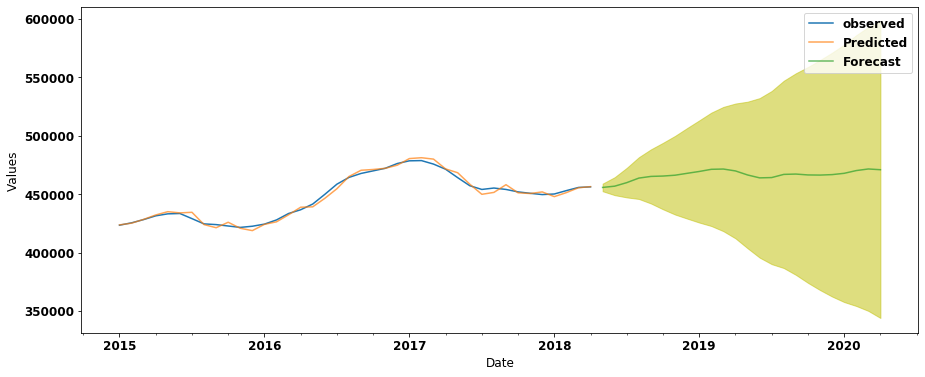

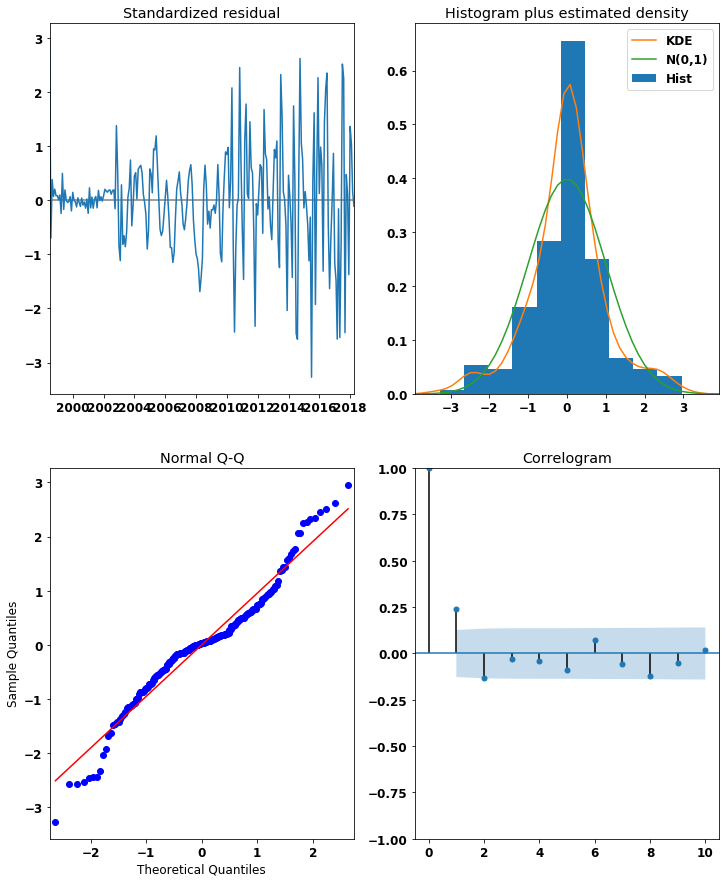

C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


60641


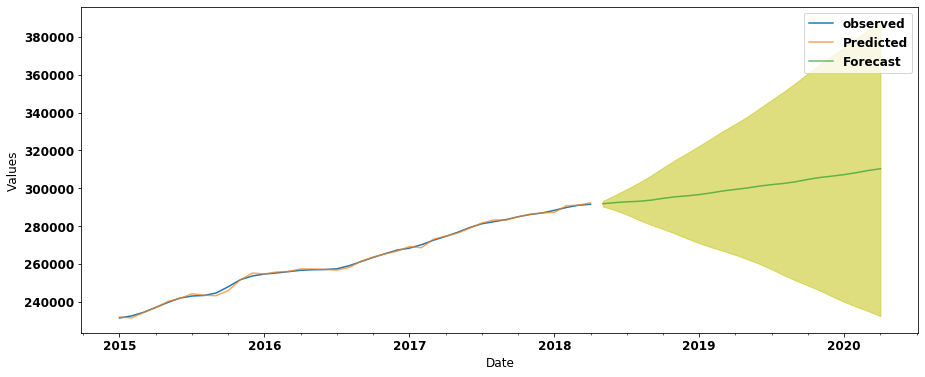

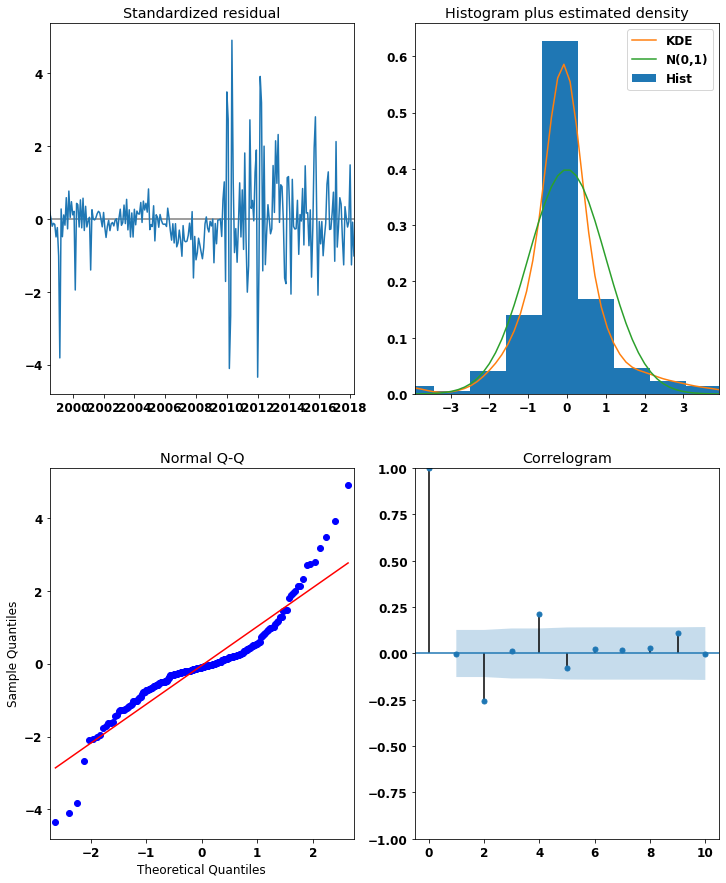

C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


60660


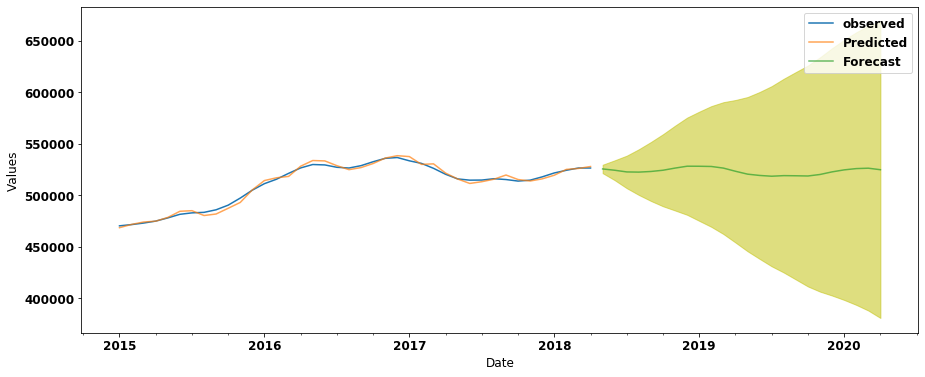

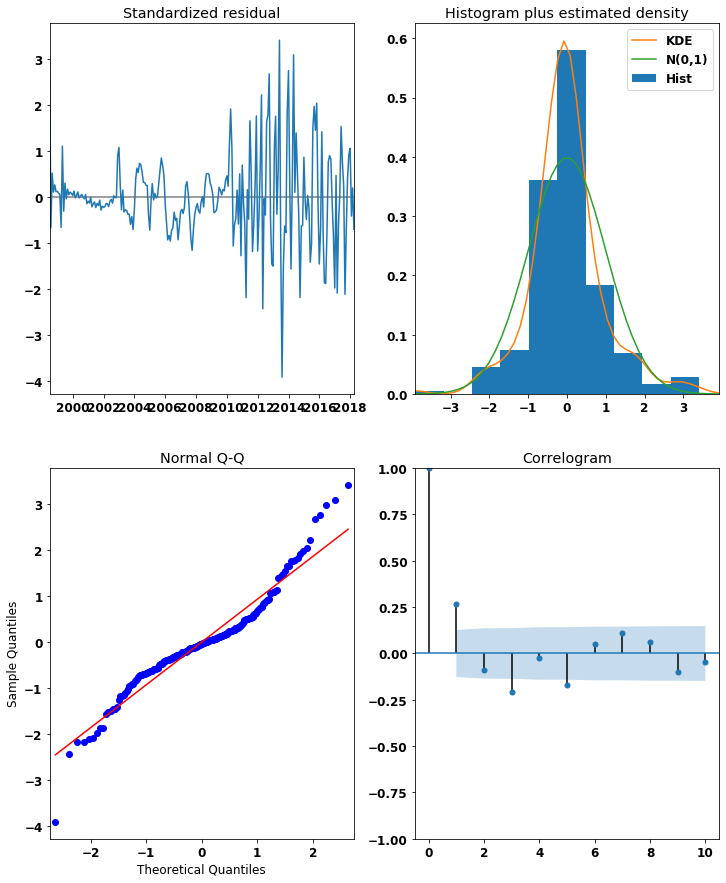

C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


60608


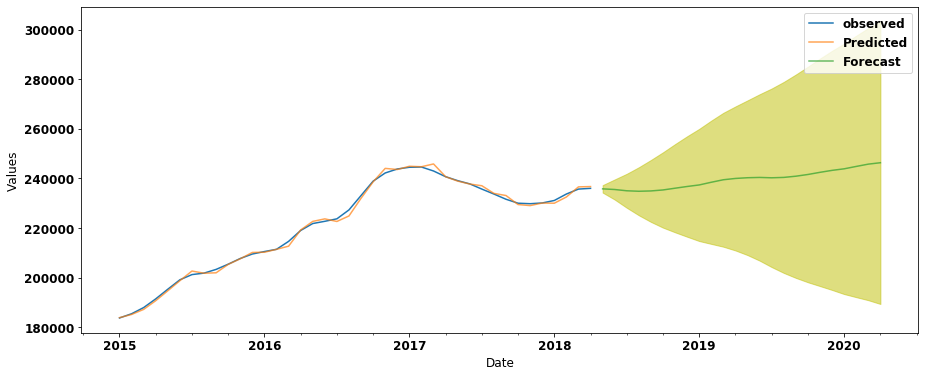

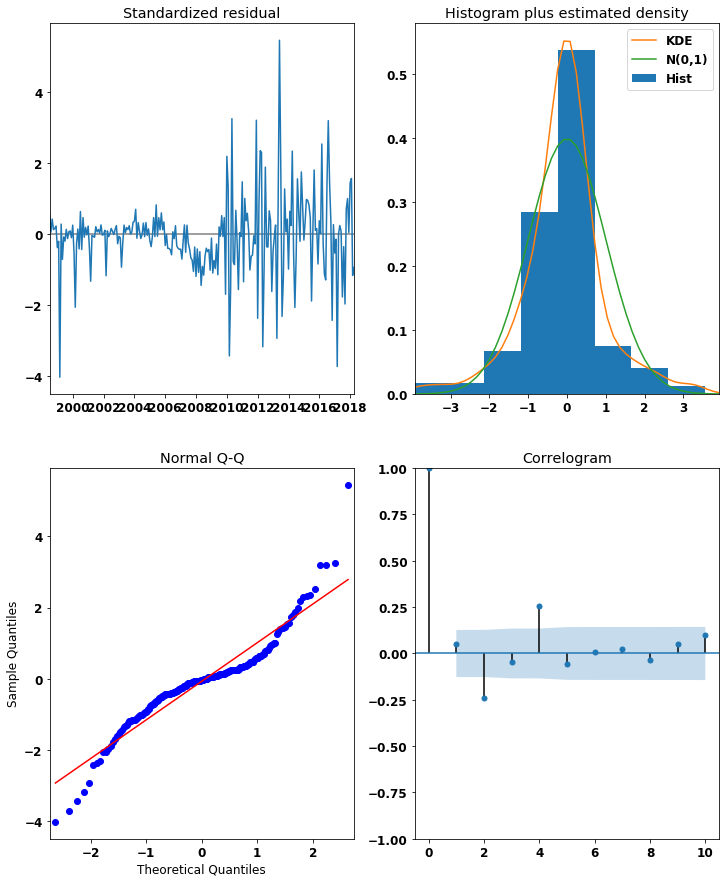

C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


60638


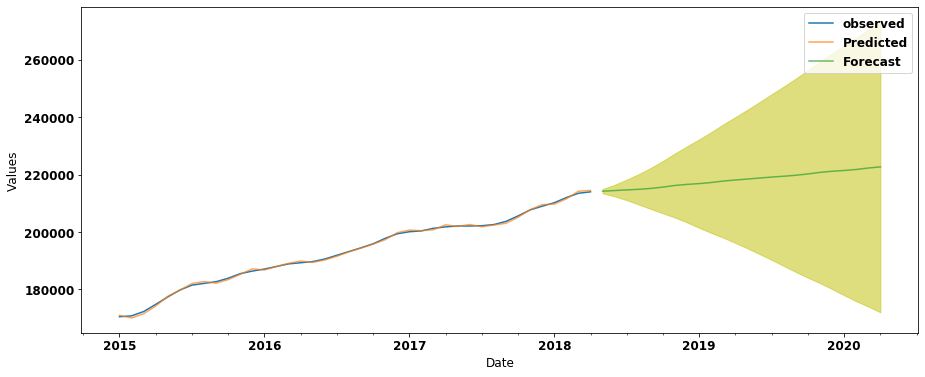

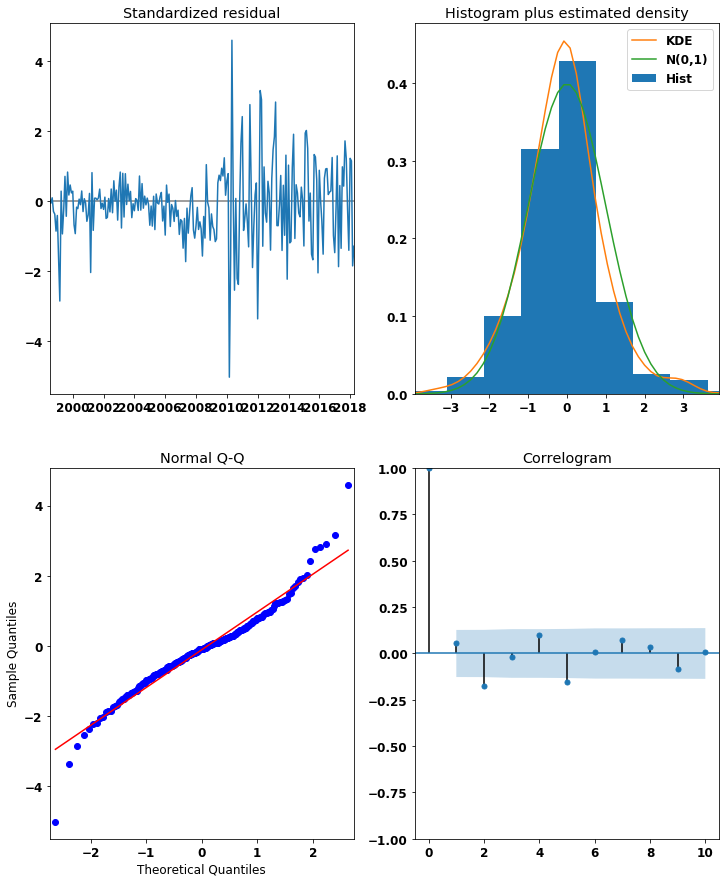

C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


60639


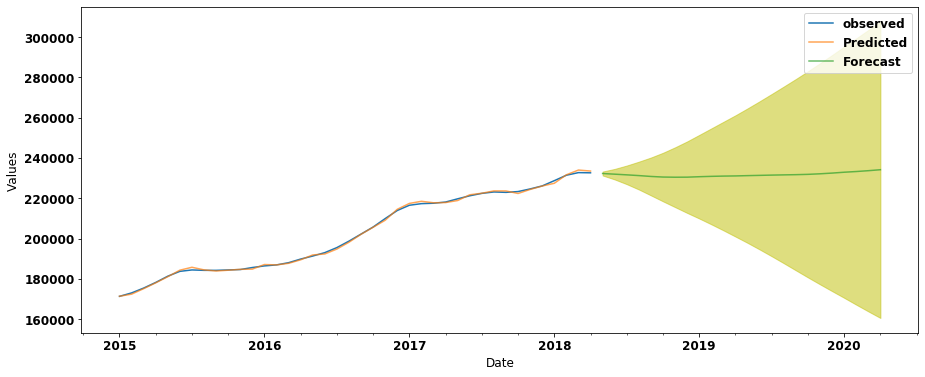

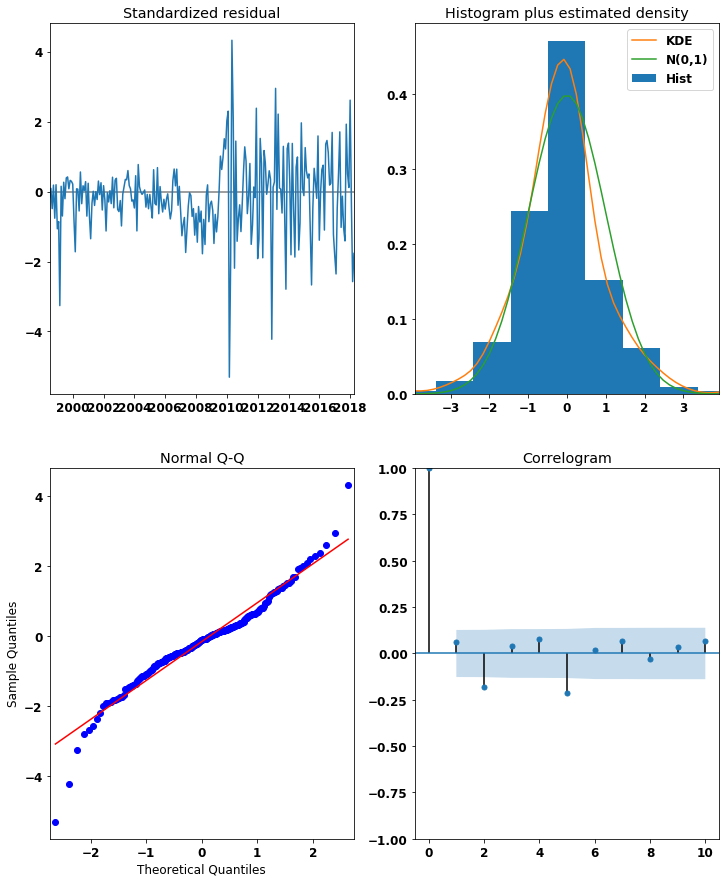

C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


60630


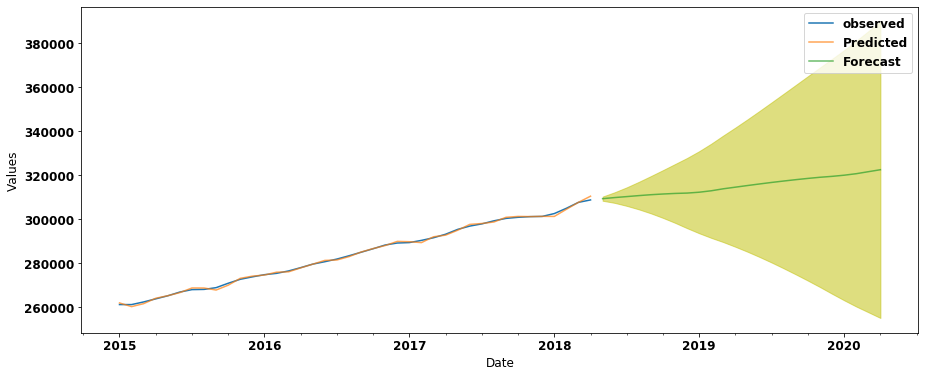

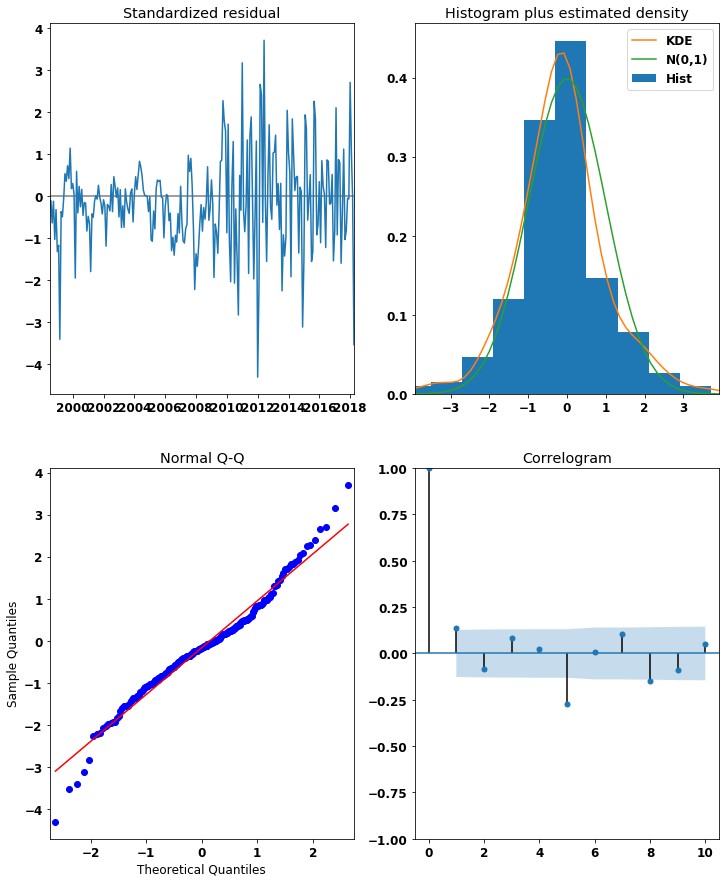

C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


60643


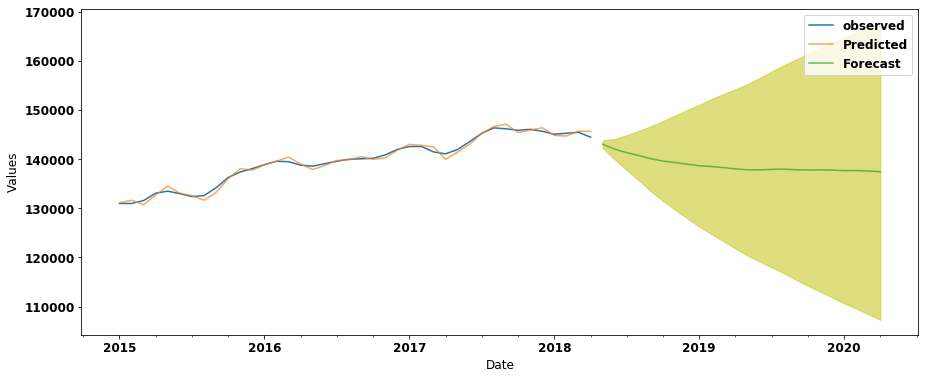

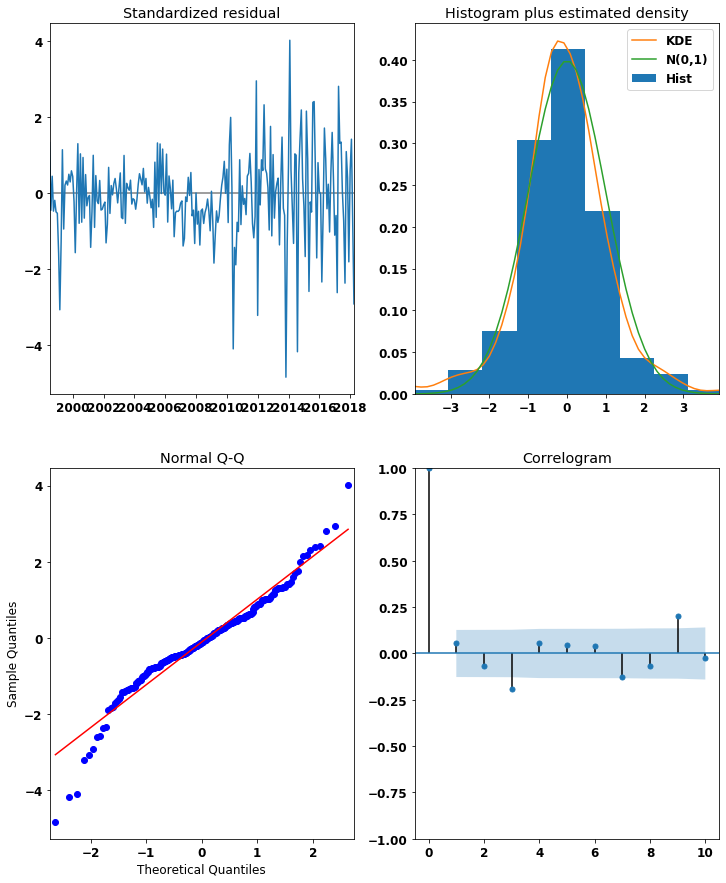

C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


60632


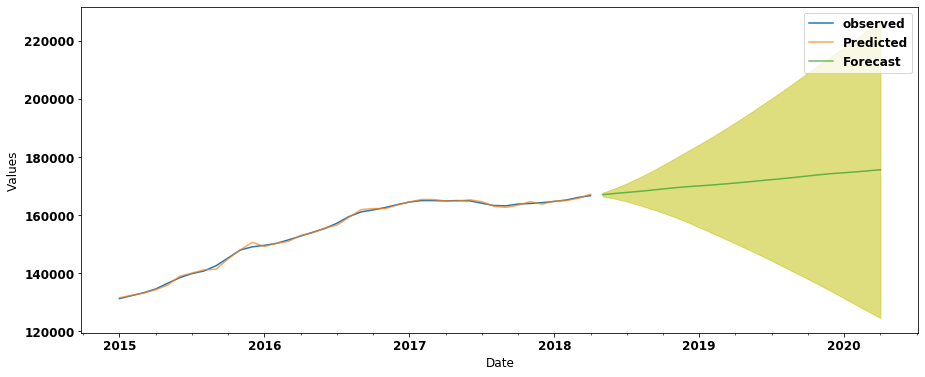

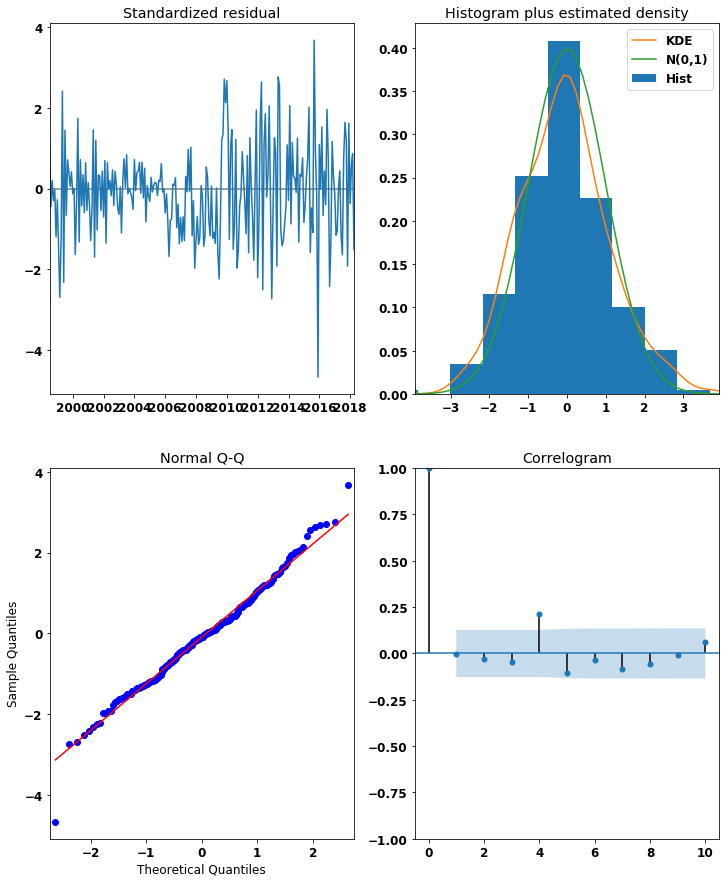

C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


60605


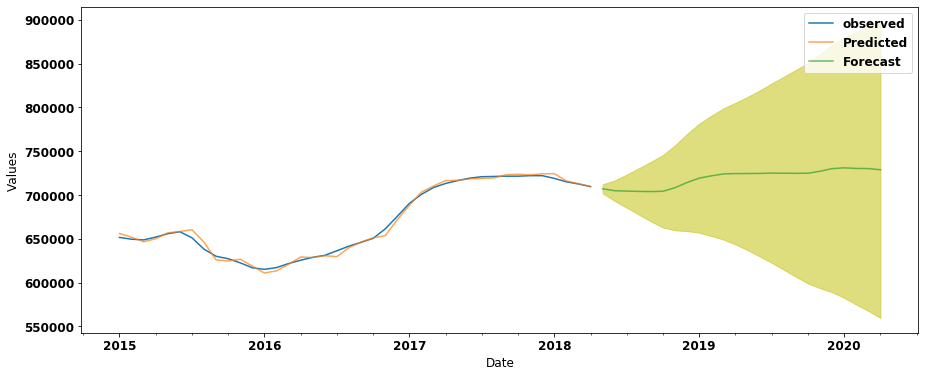

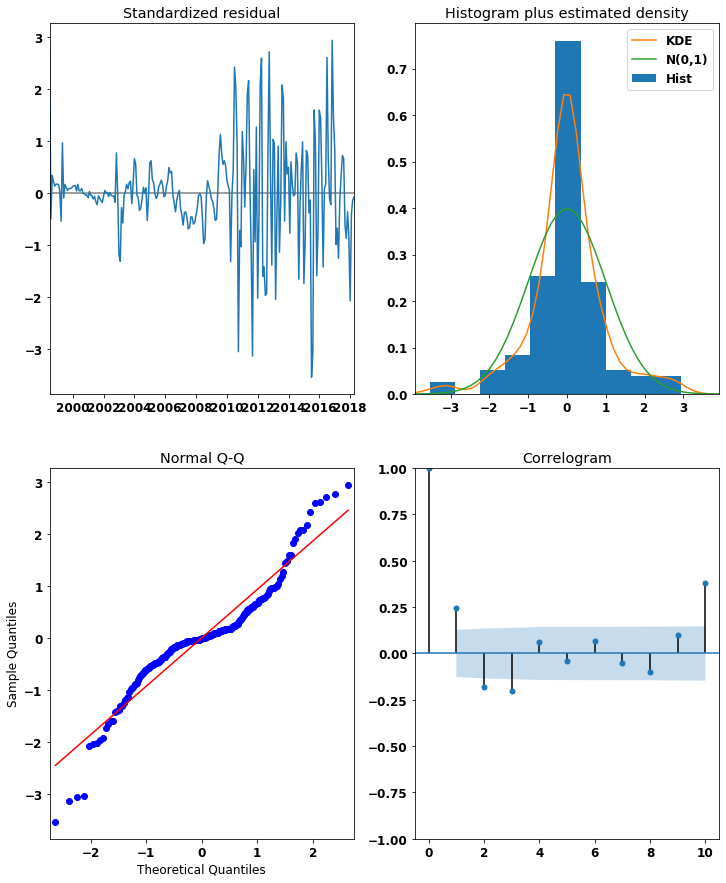

C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


60645


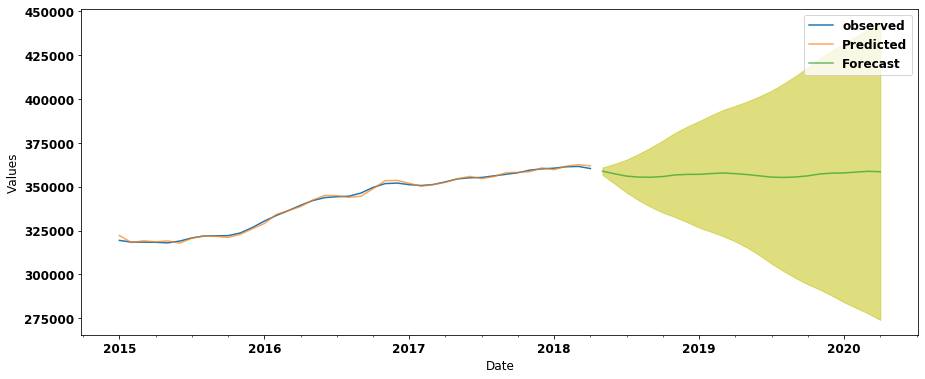

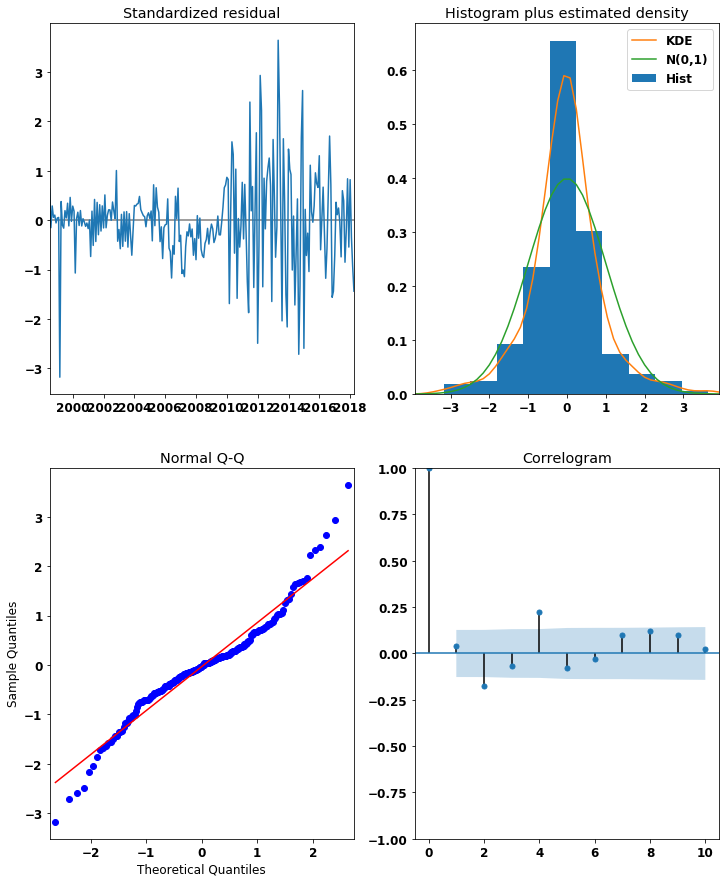

C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


60651


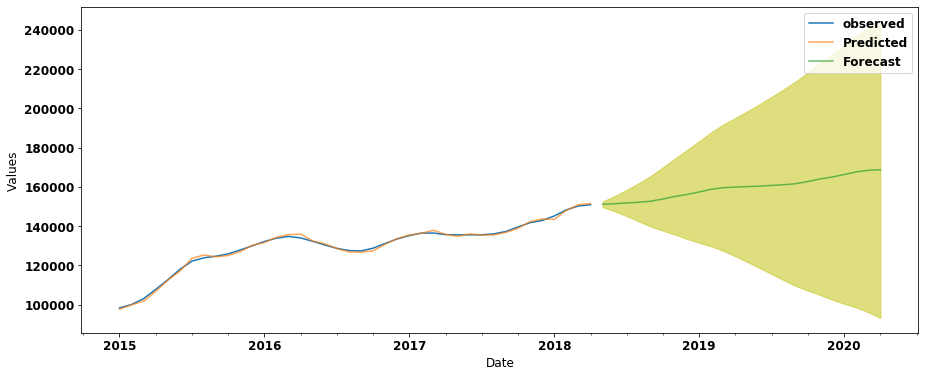

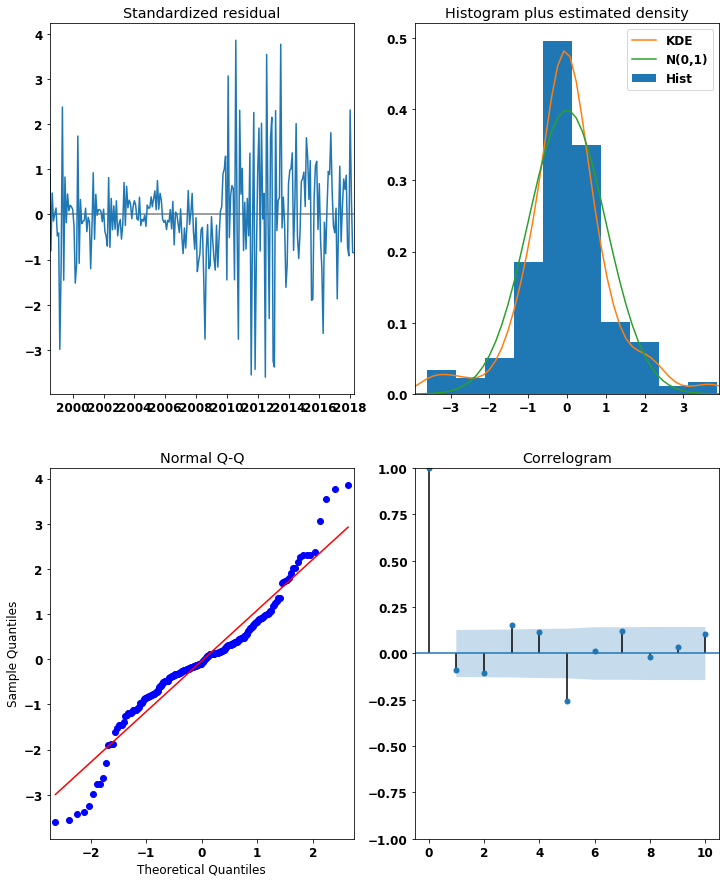

C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


60653


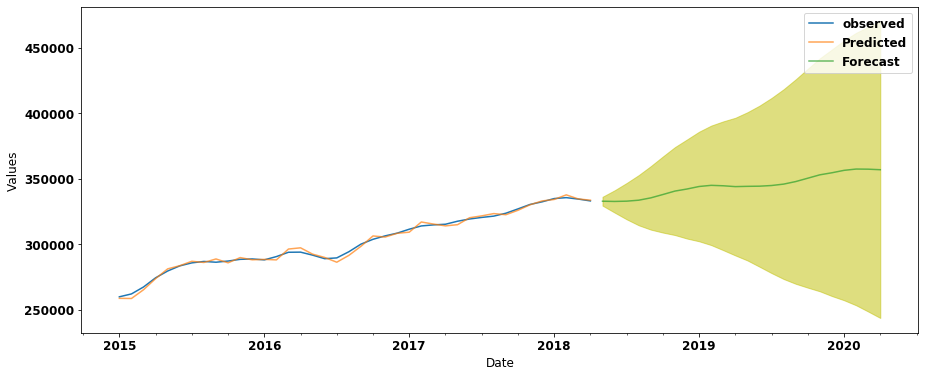

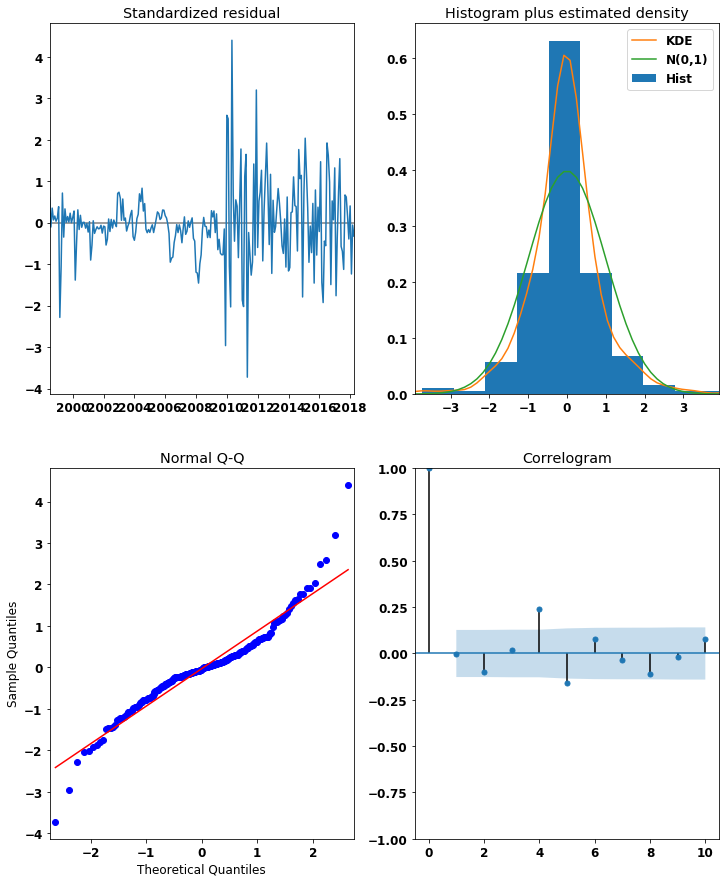

C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


60654


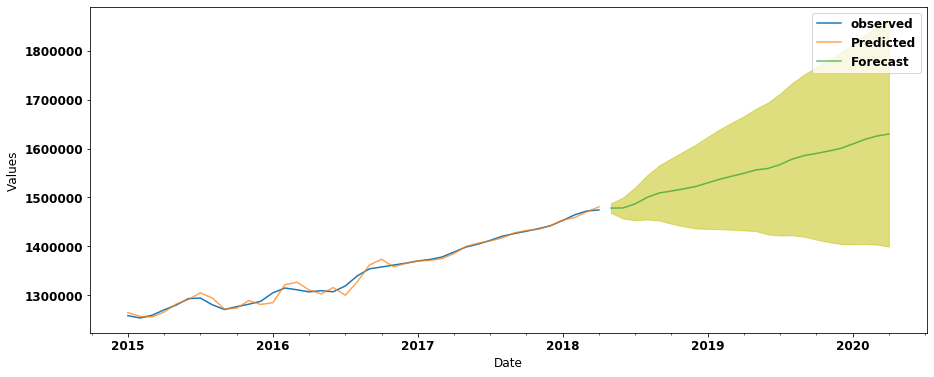

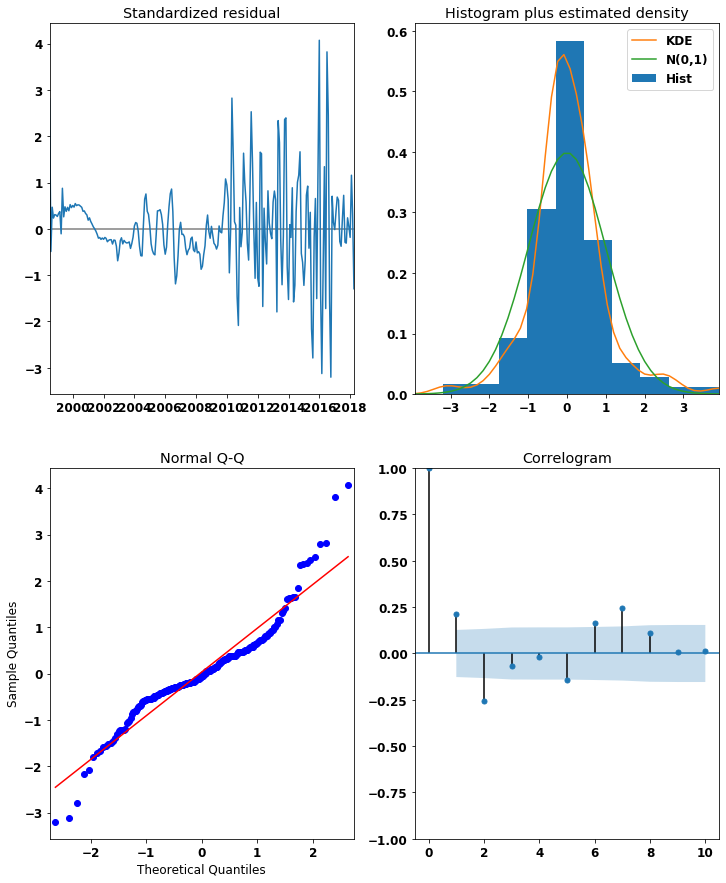

C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


60612


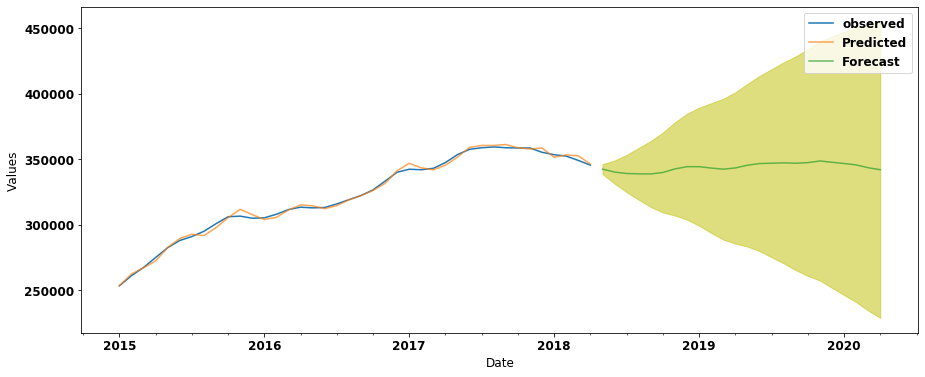

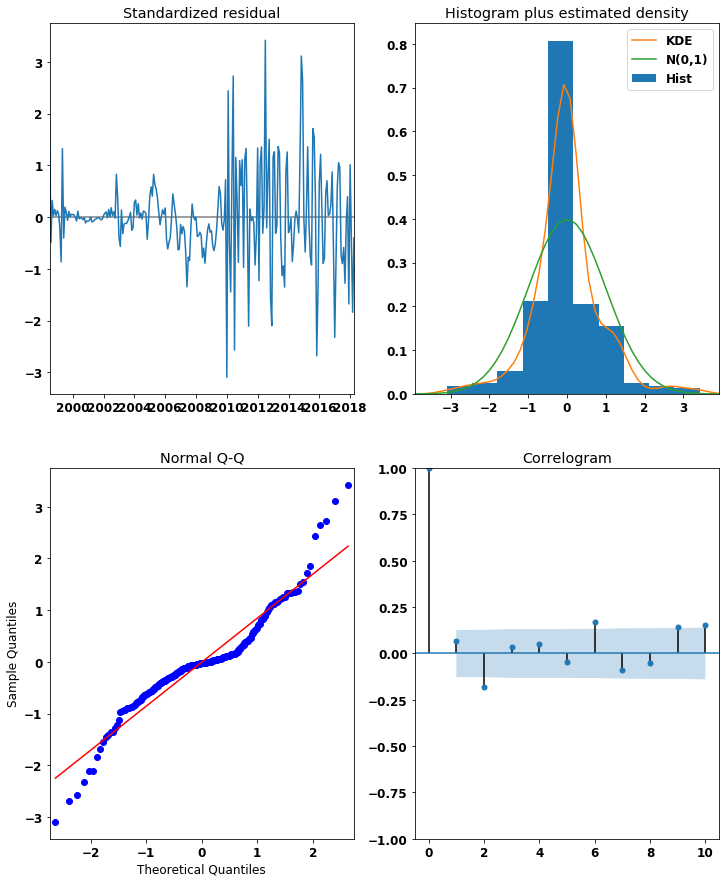

C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


60607


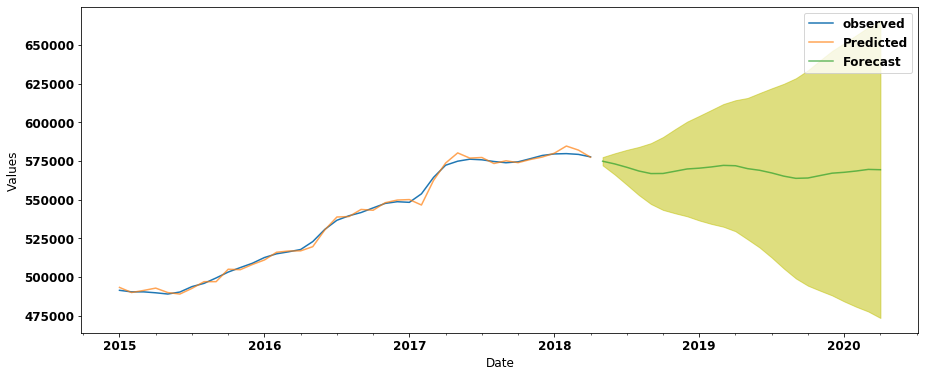

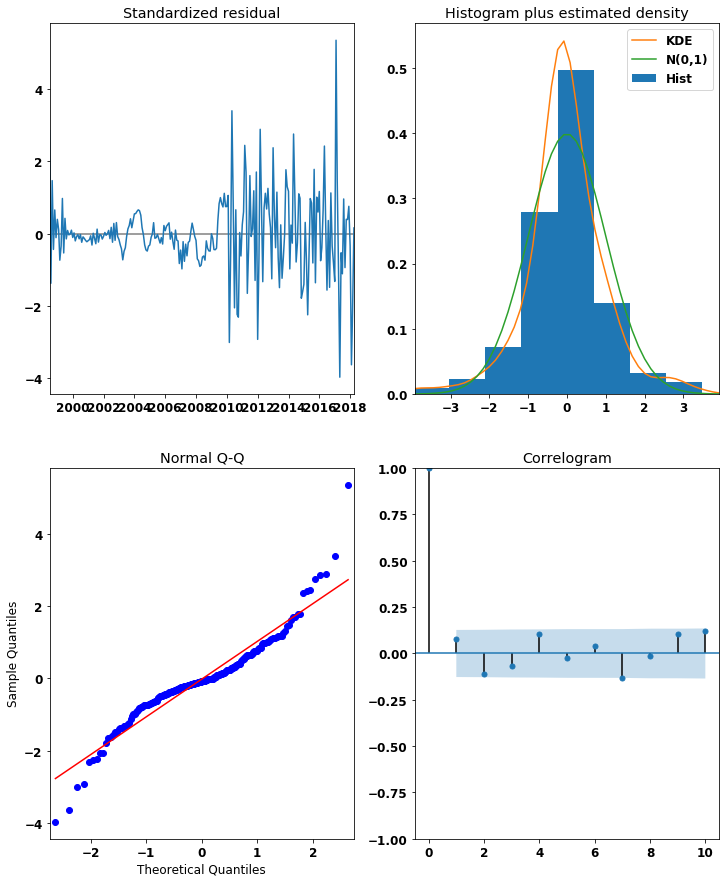

C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


60659


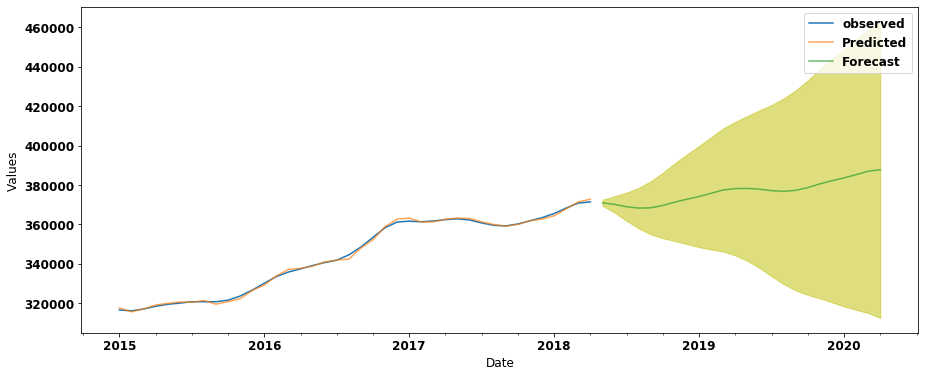

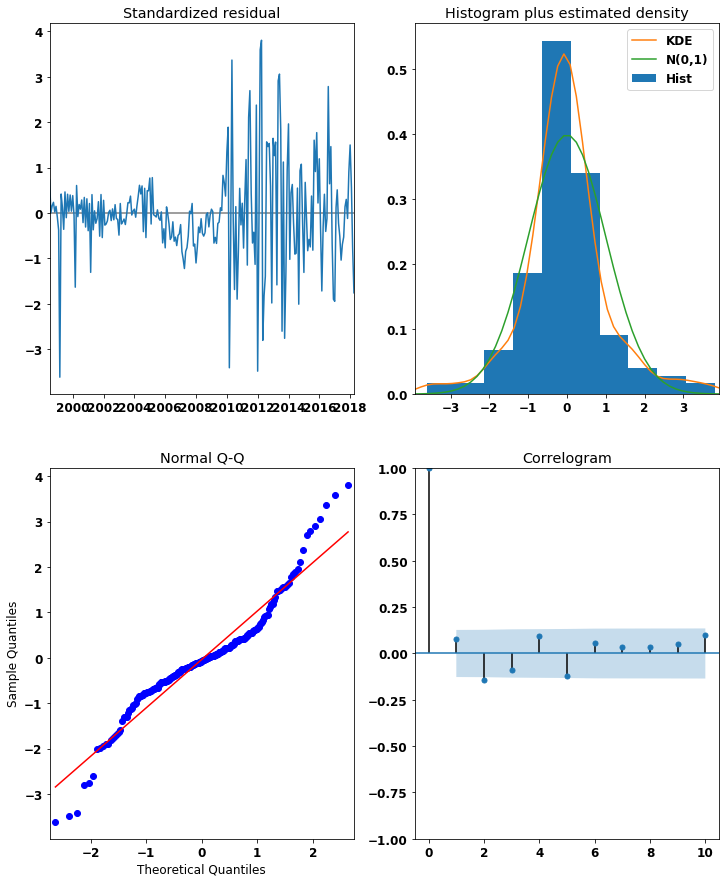

C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


60652


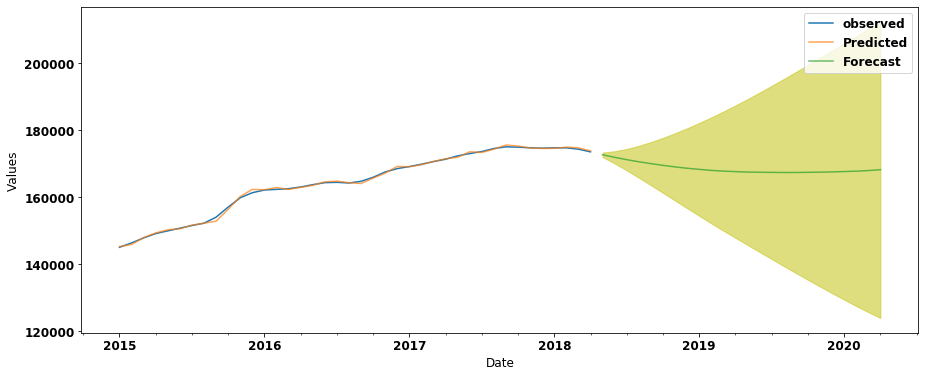

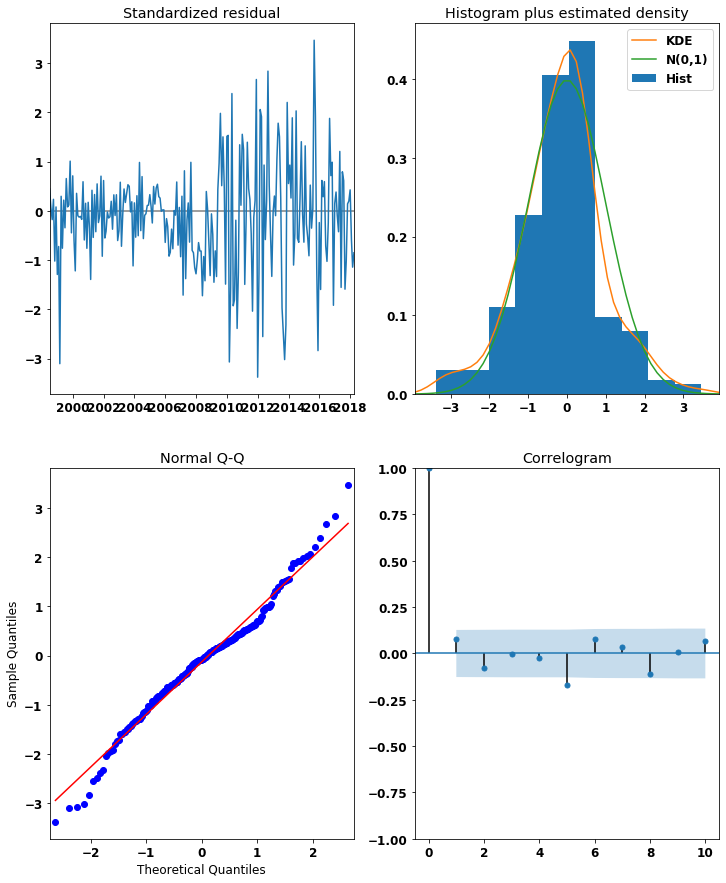

C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


60631


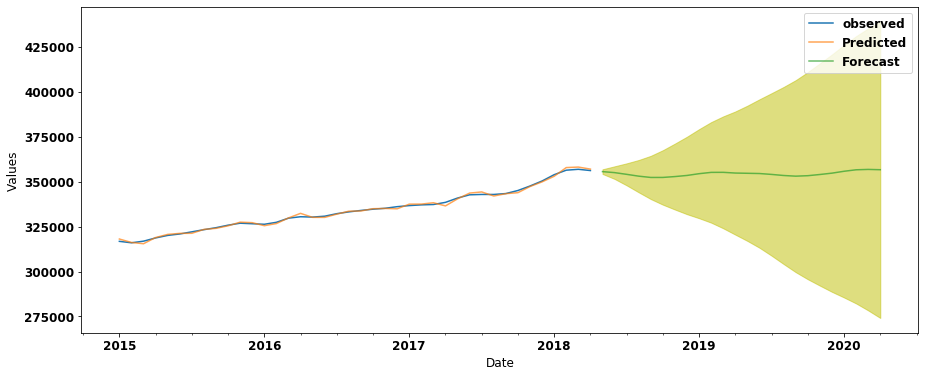

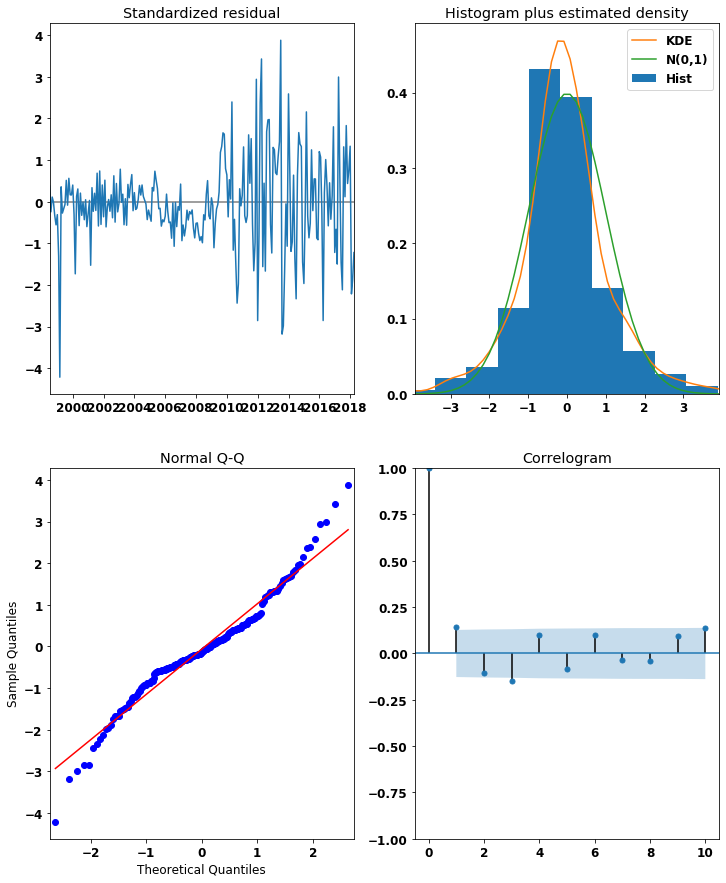

C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


60656


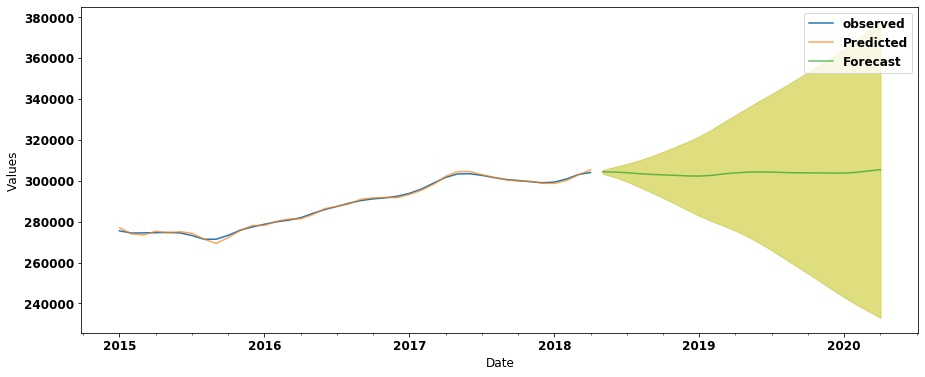

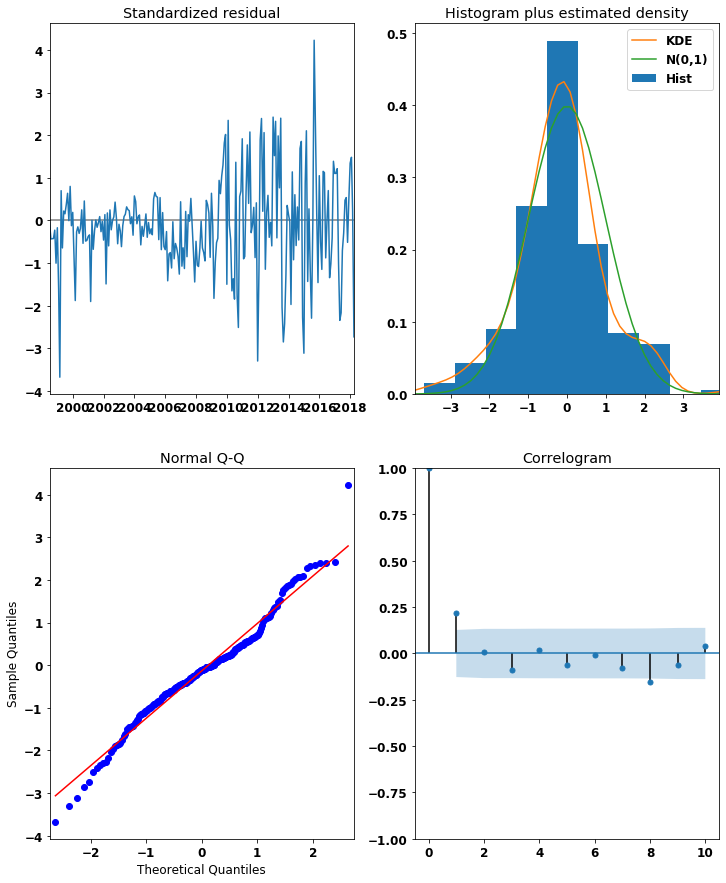

C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


60655


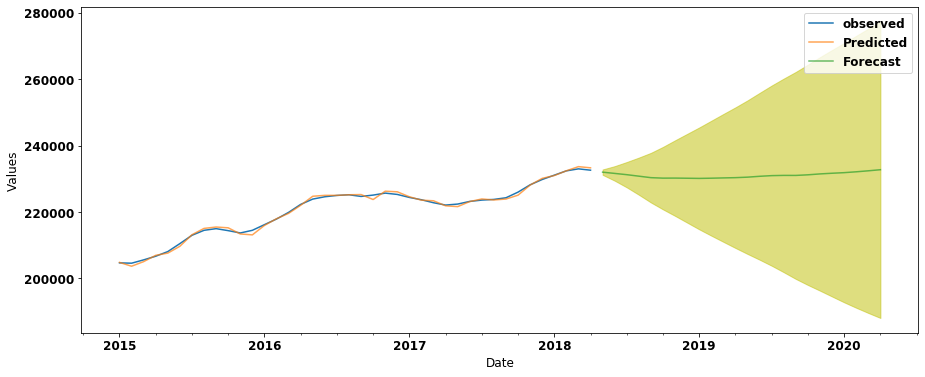

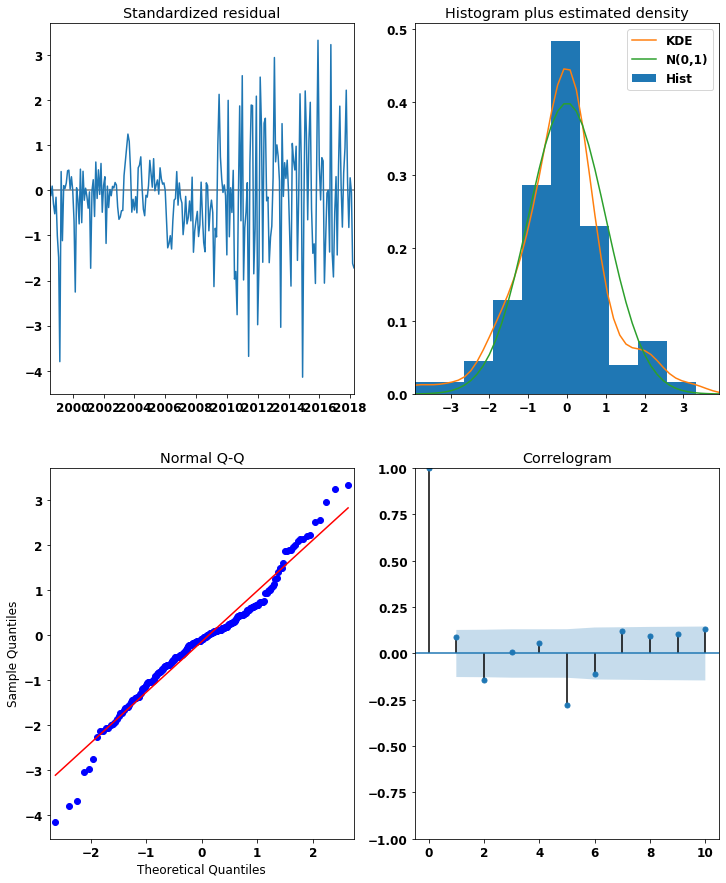

C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


60646


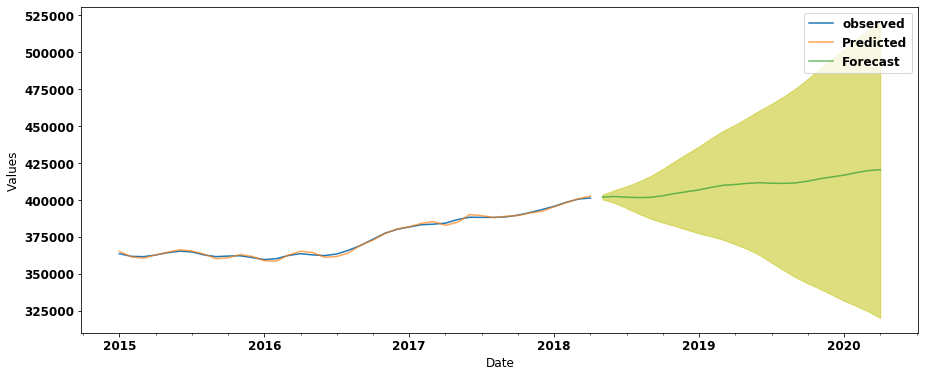

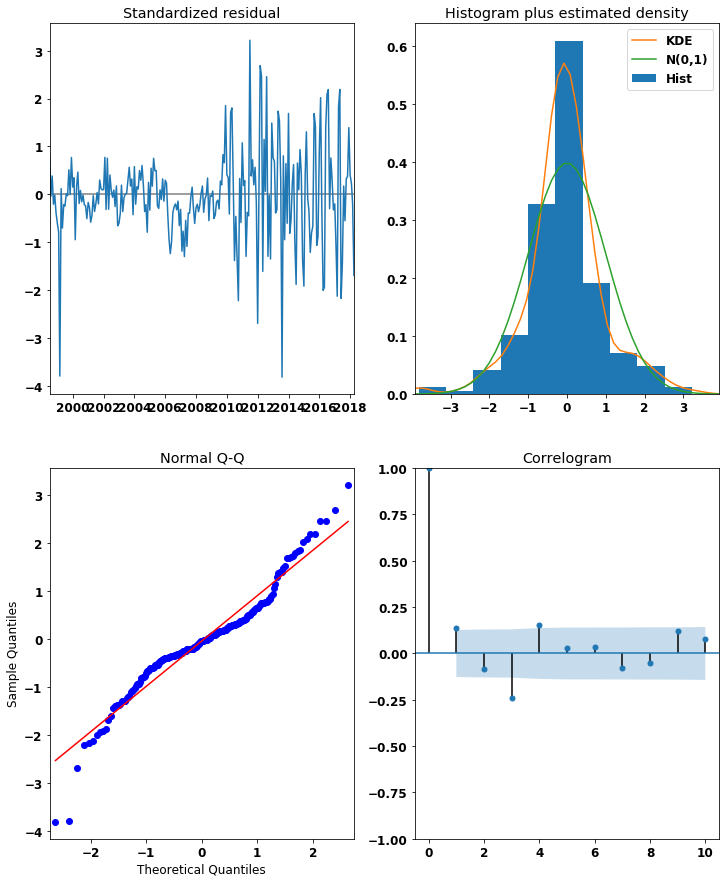

C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


60642


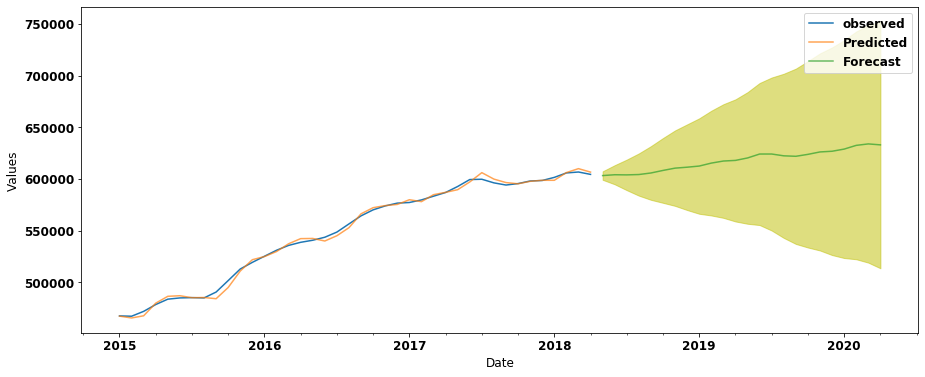

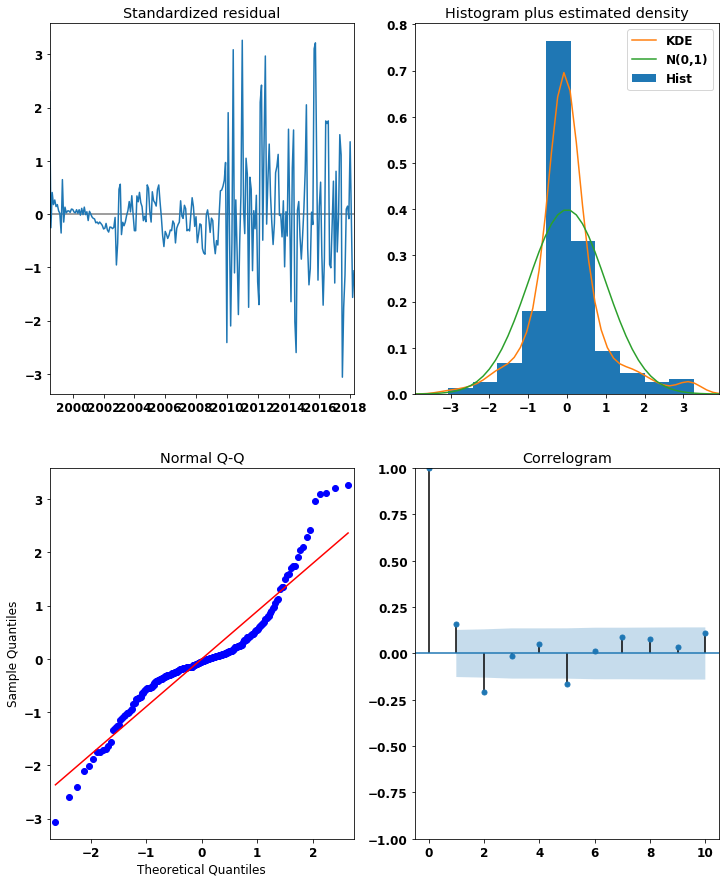

C:\Users\lraic\Anaconda3\envs\learn-env\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


60633


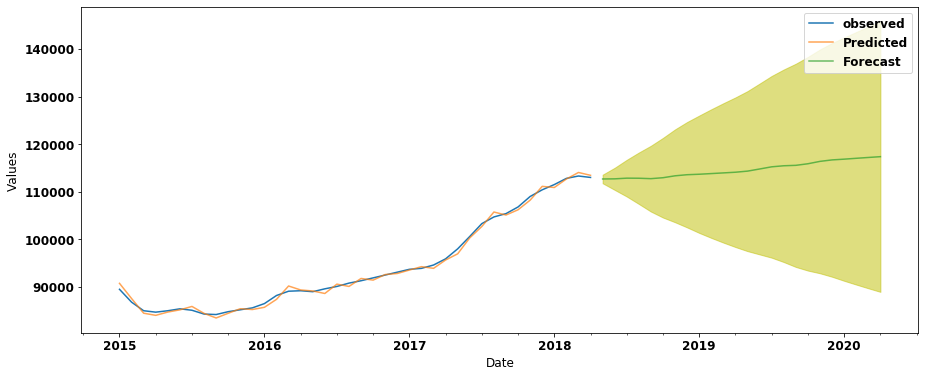

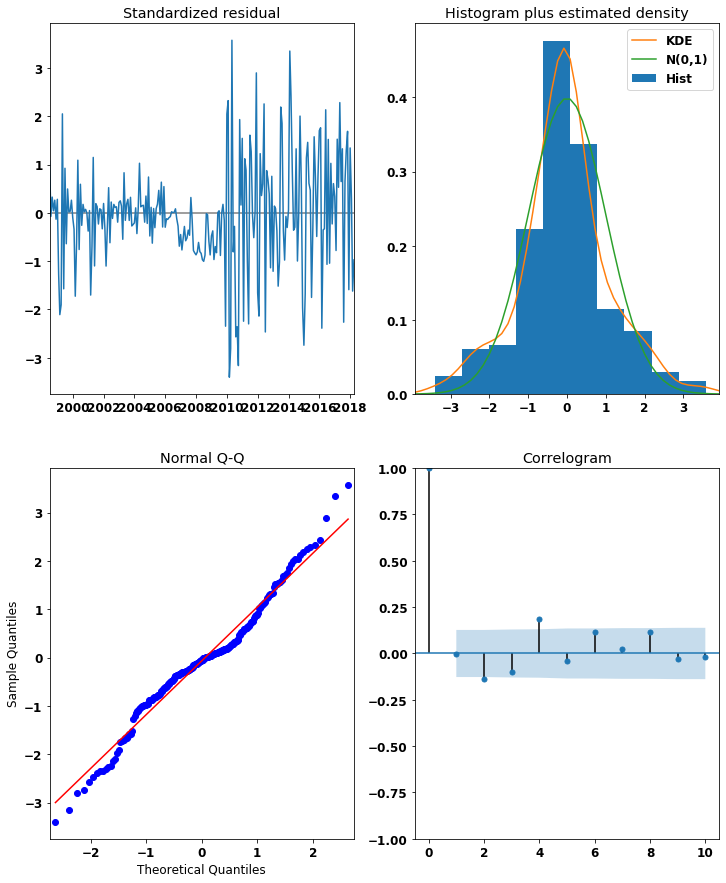

In [38]:
pred_df = pd.DataFrame()
known_RMSE = {}
forecast_2019_04 = {}
confid_min = {}
confid_max = {}
profit = {}
roi = {}
for comb in best_combs:
    
    if comb[0] == 60611:
        
        df = melted_df1.loc[melted_df1['RegionName'] == comb[0]].value.dropna()
        
        mod = sm.tsa.statespace.SARIMAX(df,
                                    order=comb[1],
                                    seasonal_order=comb[2],
                                    enforce_stationarity=False,
                                    enforce_invertibility=False,)

        output = mod.fit()
        pred = output.get_prediction(start=pd.to_datetime('2013-07-01'), dynamic=False)
        test_forecasted = pred.predicted_mean
        test_truth = test['2013-07-01':].value
        test_forecasted = test_forecasted['2013-07-01':]
    else:
        
        df = melted_df1.loc[melted_df1['RegionName'] == comb[0]].value.dropna()
       
        mod = sm.tsa.statespace.SARIMAX(df,
                                    order=comb[1],
                                    seasonal_order=comb[2],
                                    enforce_stationarity=False,
                                    enforce_invertibility=False)

        output = mod.fit()
        pred = output.get_prediction(start=pd.to_datetime('1996-04-01'), dynamic=False)
        test_forecasted = pred.predicted_mean
        test_truth = test['1996-04-01':].value
        test_forecasted = test_forecasted['1996-04-01':]
    error = mean_squared_error(test_forecasted, test_truth)
    known_RMSE[comb[0]] = np.sqrt(error)
    forecast = output.get_forecast(steps=24)
    forecast_2019_04[comb[0]] = forecast.predicted_mean['2019-04-01']
    pred_conf = forecast.conf_int()
    confid_min[comb[0]] = pred_conf[pred_conf.index == '2019-04-01']['lower value'][0]
    confid_max[comb[0]] = pred_conf[pred_conf.index == '2019-04-01']['upper value'][0]
    val_04_18 = melted_df1.loc[melted_df1['RegionName'] == comb[0]].value[-1]
    profit[comb[0]] = forecast.predicted_mean['2019-04'] - val_04_18
    roi[comb[0]] = profit[comb[0]]/val_04_18
    
    print(comb[0])
    make_pred_image(df, test_forecasted, forecast)
    output.plot_diagnostics(figsize=(12, 15))
    plt.show()
    
    

pred_df['zipcode'] = known_RMSE.keys()
pred_df['known_RMSE'] = known_RMSE.values()
pred_df['forecast_2019_04'] = forecast_2019_04.values()
pred_df['confid_min'] = confid_min.values()
pred_df['confid_max'] = confid_max.values()
pred_df['profit'] = profit.values()
pred_df['roi'] = roi.values()

Cleaning up how the data is displayed to make it easier to read in the dataframe

In [39]:
pred_df['roi'] = pred_df['roi'].apply(lambda x: round(x[0], 2))

In [40]:
pred_df['profit'] = pred_df['profit'].apply(lambda x: round(x[0]))

In [41]:
pred_df['2018_04_price'] = pred_df['forecast_2019_04'] - pred_df['profit']

In [42]:
pred_df['2018_04_price'] = pred_df['2018_04_price'].apply(lambda x: round(x))

In [43]:
pred_df['forecast_2019_04'] = pred_df['forecast_2019_04'].apply(lambda x: round(x))

In [44]:
pred_df['known_RMSE'] = pred_df['known_RMSE'].apply(lambda x: round(x, 2))

In [45]:
pred_df['confid_min'] = pred_df['confid_min'].apply(lambda x: round(x))

In [46]:
pred_df['confid_max'] = pred_df['confid_max'].apply(lambda x: round(x))

In [47]:
pred_df['max_loss'] = pred_df['2018_04_price'] - pred_df['confid_min']

In [48]:
pred_df['loi'] = (pred_df['2018_04_price'] - pred_df['confid_min'])/pred_df['2018_04_price']

In [49]:
pred_df.sort_values(by=['profit', 'roi'], ascending=False).head(10)

zipcode  known_RMSE  forecast_2019_04  confid_min  confid_max  profit  \
30    60654    41723.09           1549519     1432758     1666279   75019   
5     60613   279495.55           1089697     1028112     1151282   34397   
0     60657   255816.74           1059517      999591     1119442   28917   
12    60634   785861.42            291886      262907      320864   24286   
10    60611   261304.85           1511077     1370413     1651741   17877   
26    60605   483687.57            724380      643558      805202   14880   
17    60615   639597.28            469846      412124      527568   13646   
39    60642   585318.63            617928      558864      676992   13528   
2     60640   445752.60            796310      712415      880204   13510   
4     60618   688733.39            476333      435030      517635   12033   

     roi  2018_04_price  max_loss       loi  
30  0.05        1474500     41742  0.028309  
5   0.03        1055300     27188  0.025763  
0   0.03        1030600     31009  0.030088  
12  0.09         267600      4693  0.017537  
10  0.01        1493200    122787  0.082231  
26  0.02         709500     65942  0.092942  
17  0.03         456200     44076  0.096616  
39  0.02         604400     45536  0.075341  
2   0.02         782800     70385  0.089914  
4   0.03         464300     29270  0.063041

In [50]:
pred_df.sort_values(by=['roi', 'profit'], ascending=False).head(10)

zipcode  known_RMSE  forecast_2019_04  confid_min  confid_max  profit  \
12    60634   785861.42            291886      262907      320864   24286   
11    60620   902260.95            139640      119745      159535    9340   
8     60619   897425.59            138558      116567      160549    8958   
28    60651   887125.58            159904      124621      195187    9004   
30    60654    41723.09           1549519     1432758     1666279   75019   
5     60613   279495.55           1089697     1028112     1151282   34397   
0     60657   255816.74           1059517      999591     1119442   28917   
17    60615   639597.28            469846      412124      527568   13646   
4     60618   688733.39            476333      435030      517635   12033   
29    60653   752134.16            343919      291379      396460   10919   

     roi  2018_04_price  max_loss       loi  
12  0.09         267600      4693  0.017537  
11  0.07         130300     10555  0.081005  
8   0.07         129600     13033  0.100563  
28  0.06         150900     26279  0.174148  
30  0.05        1474500     41742  0.028309  
5   0.03        1055300     27188  0.025763  
0   0.03        1030600     31009  0.030088  
17  0.03         456200     44076  0.096616  
4   0.03         464300     29270  0.063041  
29  0.03         333000     41621  0.124988

# Step 5: Interpreting Results

There is no best or best 5 for the city of Chicago.  
On any of them, there is the possibilty of a loss and the gain is not so much, esspecially concidering that there would be other costs involved as well.  
I would suggest not investing in real estate in the city of Chicago

The top ones are would be these:

In [68]:
pred_df.sort_values(by=['profit', 'roi'], ascending=False).head(4)

zipcode  known_RMSE  forecast_2019_04  confid_min  confid_max  profit  \
30    60654    41723.09           1549519     1432758     1666279   75019   
5     60613   279495.55           1089697     1028112     1151282   34397   
0     60657   255816.74           1059517      999591     1119442   28917   
12    60634   785861.42            291886      262907      320864   24286   

     roi  2018_04_price  max_loss       loi  
30  0.05        1474500     41742  0.028309  
5   0.03        1055300     27188  0.025763  
0   0.03        1030600     31009  0.030088  
12  0.09         267600      4693  0.017537

<img src='5_best.png'>

As we can see they are not very good projections and therefore I would not advise to invest in them